In [1]:
# Data wrangling
import pandas                  as     pd
import numpy                   as     np
import missingno               as     msno

# Predictive modeling
from   sklearn.linear_model    import LinearRegression
from   sklearn.metrics         import mean_squared_error, r2_score
from   sklearn.model_selection import train_test_split
import statsmodels.api         as     sm
import scipy.stats             as     stats

# Visualization
import seaborn                 as     sns
import matplotlib.pyplot       as     plt
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

# Data Wrangling

In [2]:
# Import dataset into Pandas DataFrame
df_raw    = pd.read_csv("../dat/ship_data.csv")
n_records = df_raw.shape[0]

# Check column names and data types
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16248 entries, 0 to 16247
Data columns (total 26 columns):
Time                                                          16248 non-null int64
Main Engine Fuel Consumption (MT/day)                         16085 non-null float64
Main Engine Using HFO (bool)                                  16085 non-null float64
Main Engine Using MGO (bool)                                  16085 non-null float64
Draft Forward (meters)                                        16085 non-null float64
Draft Aft (meters)                                            16085 non-null float64
Draft Mid-1 (meters)                                          16085 non-null float64
Draft Mid-2 (meters)                                          16085 non-null float64
Shaft Speed (RPM)                                             16085 non-null float64
Shaft Torque (kNm)                                            16085 non-null float64
Shaft Power (kW)                           

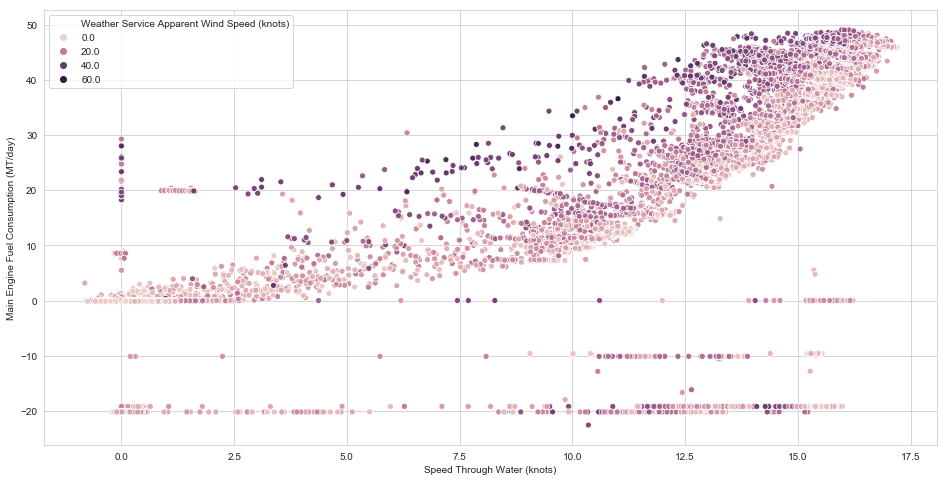

In [3]:
# Plot raw data
plt.figure(figsize=(16,8))
sns.scatterplot(x    = 'Speed Through Water (knots)',
                y    = 'Main Engine Fuel Consumption (MT/day)',
                hue  = 'Weather Service Apparent Wind Speed (knots)',
                data = df_raw)

In [4]:
# Create helper sublists of column names
cols_main  = df_raw.columns[0:4]
cols_draft = df_raw.columns[4:8]
cols_shaft = df_raw.columns[8:11]
cols_speed = df_raw.columns[11:15]
cols_wind  = df_raw.columns[15:19]
cols_sea   = df_raw.columns[19:23]
cols_wave  = df_raw.columns[23:26]
df_raw.shape

(16248, 26)

# Missing Records

Time                                                            0
Main Engine Fuel Consumption (MT/day)                         163
Main Engine Using HFO (bool)                                  163
Main Engine Using MGO (bool)                                  163
Draft Forward (meters)                                        163
Draft Aft (meters)                                            163
Draft Mid-1 (meters)                                          163
Draft Mid-2 (meters)                                          163
Shaft Speed (RPM)                                             163
Shaft Torque (kNm)                                            163
Shaft Power (kW)                                              163
Speed Over Ground (knots)                                     163
Speed Through Water (knots)                                   163
Heading (degrees)                                               8
Rudder Angle (degrees)                                        163
Weather Se

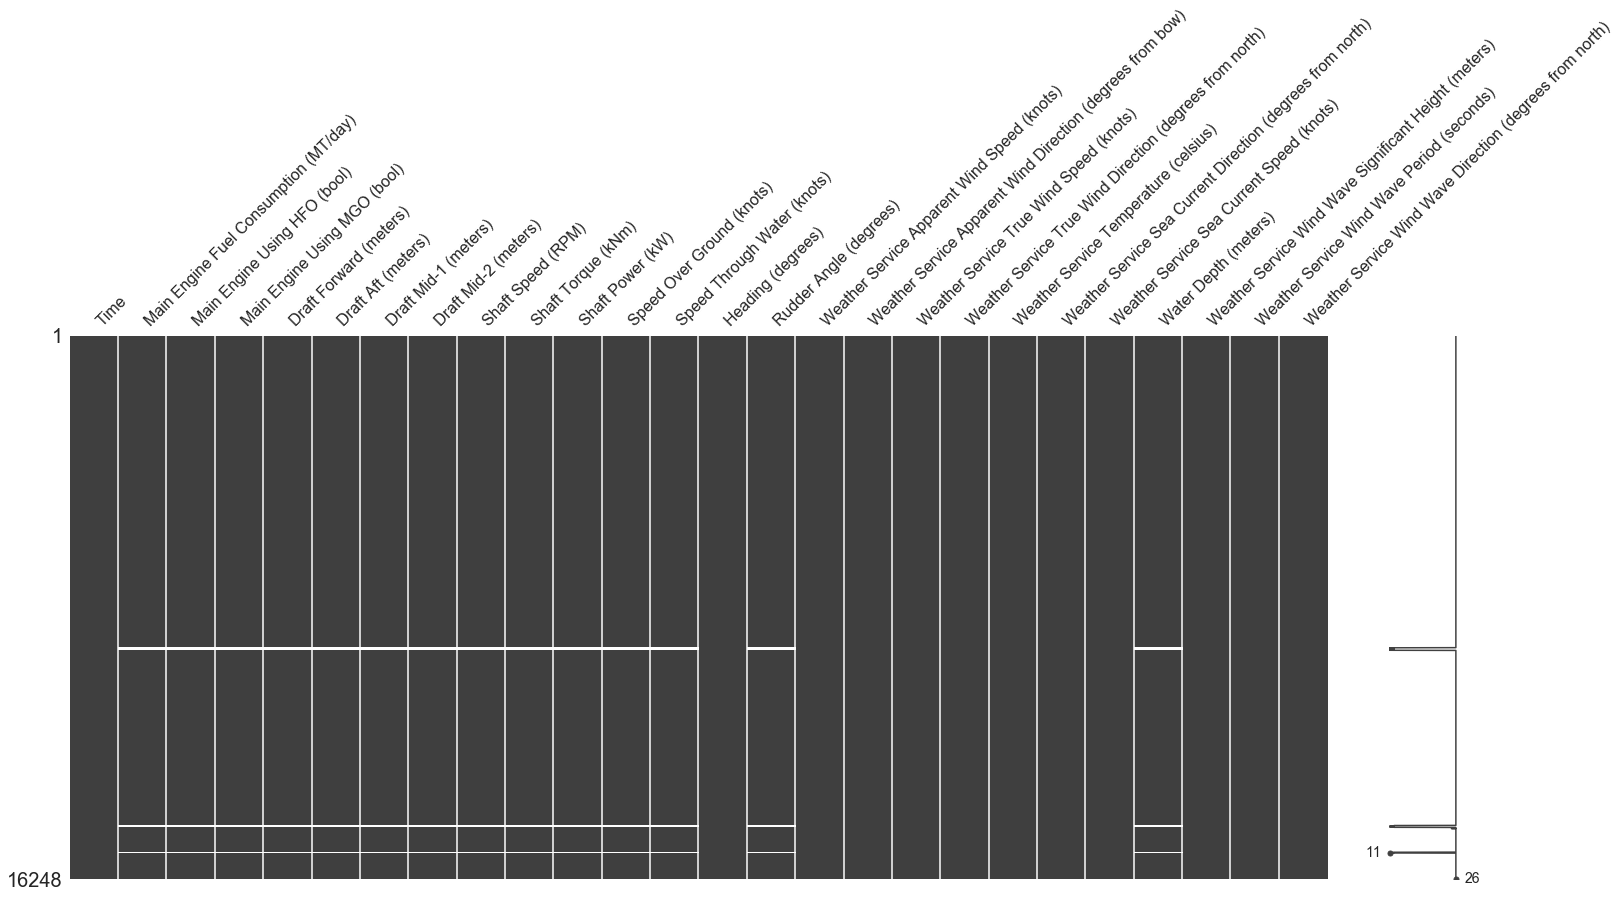

In [5]:
# Check missing values
print(df_raw.isnull().sum())
msno.matrix(df_raw)

Percentage of missing records:    1.0093549975381588
Percentage of remaining records:  98.99064500246185


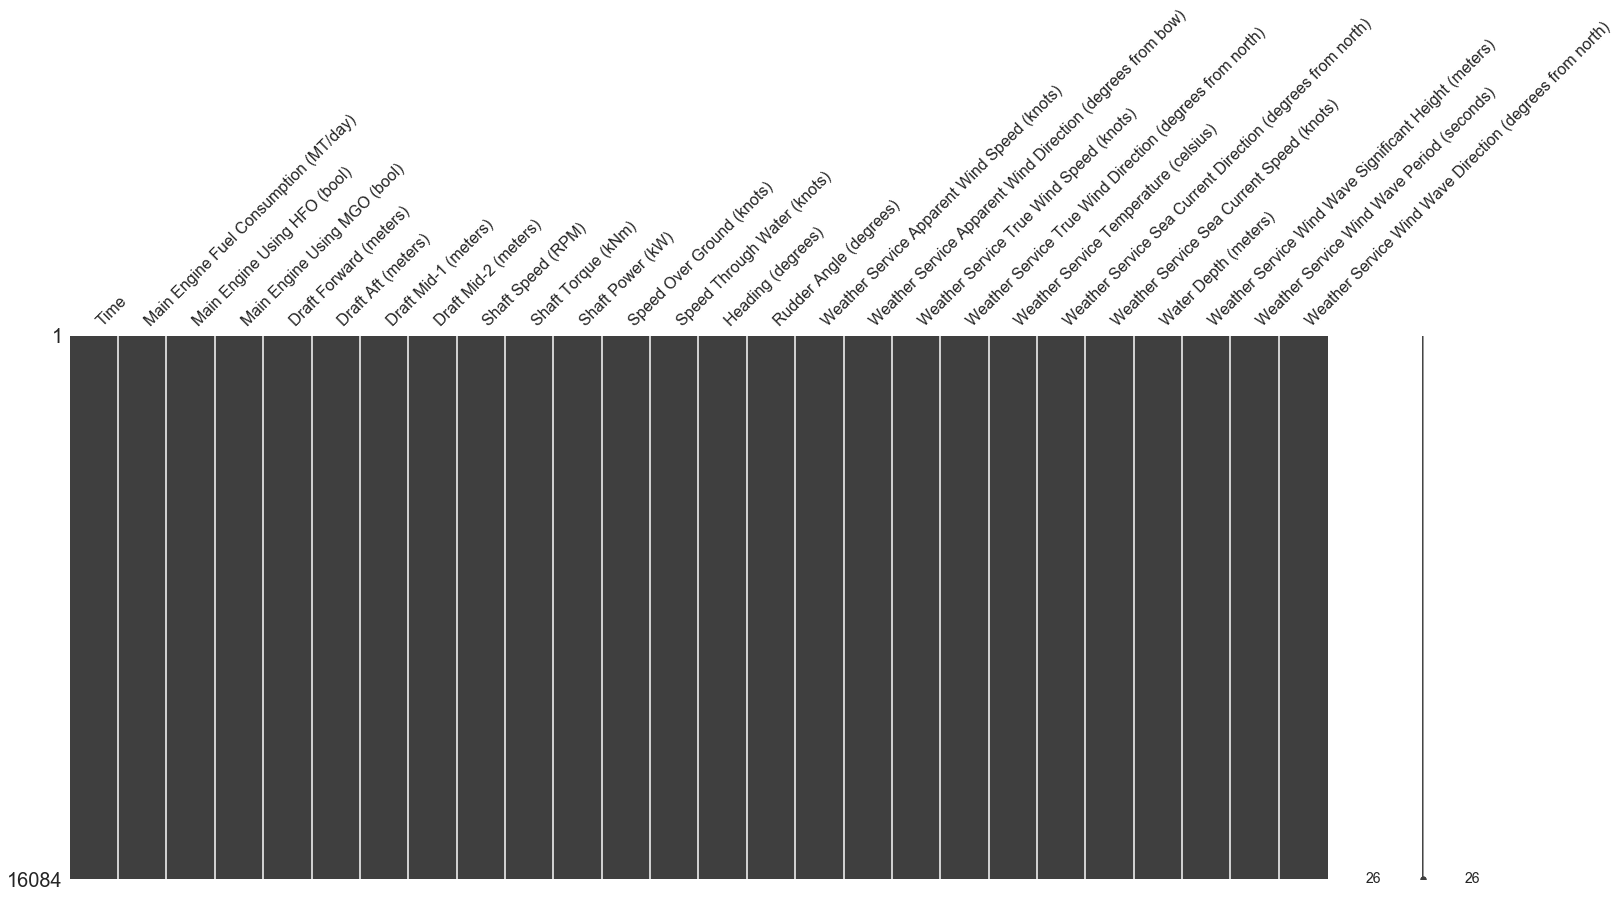

In [6]:
# Drop rows with missing target (Main Engine Fuel Consumption) ~ 1% of records
df_mod = df_raw.copy().dropna()
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of missing records:   ', ((1 - df_mod.shape[0] / n_records) * 100))
print('Percentage of remaining records: ', ((    df_mod.shape[0] / n_records) * 100))
msno.matrix(df_mod)

# Time Series Visualization

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1f0b7978>,
      dtype=object)

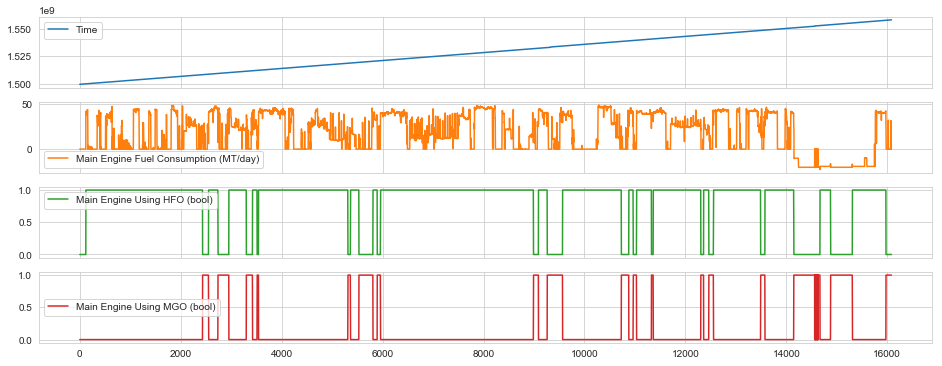

In [7]:
# Time and main engine
fig_main, axes_main = plt.subplots(len(cols_main),1, figsize=(16,len(cols_main)*1.5), sharex=True)
df_mod[cols_main].plot(subplots=True, ax=axes_main)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c207c0048>,
      dtype=object)

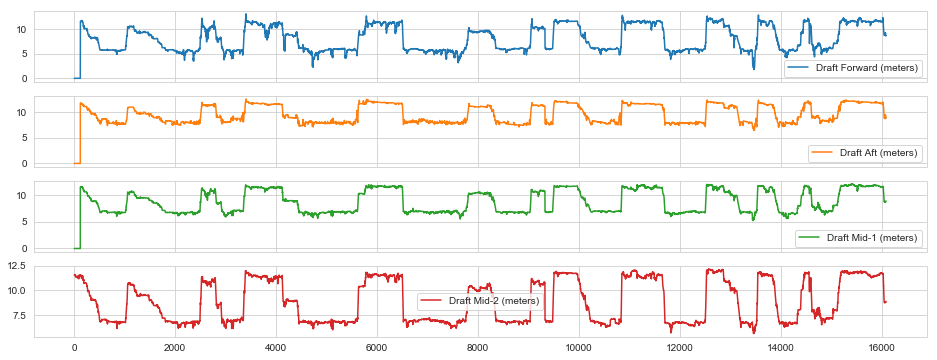

In [8]:
# Draft sensors
fig_draft, axes_draft = plt.subplots(len(cols_draft),1, figsize=(16,len(cols_draft)*1.5), sharex=True)
df_mod[cols_draft].plot(subplots=True, ax=axes_draft)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1fd73390>,
      dtype=object)

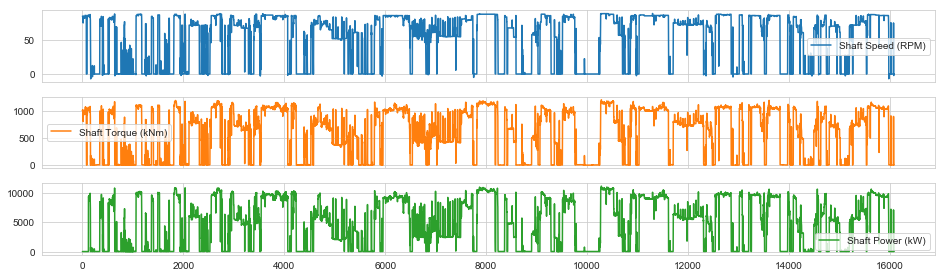

In [9]:
# Shaft performance
fig_shaft, axes_shaft = plt.subplots(len(cols_shaft),1, figsize=(16,len(cols_shaft)*1.5), sharex=True)
df_mod[cols_shaft].plot(subplots=True, ax=axes_shaft)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c229aebe0>,
      dtype=object)

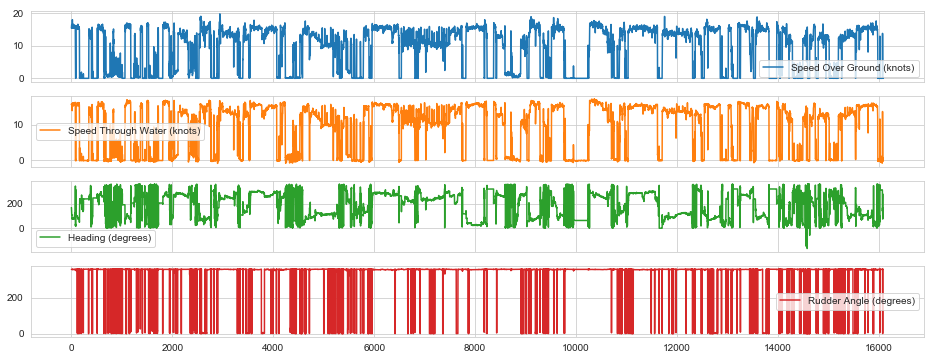

In [10]:
# Vessel speed
fig_speed, axes_speed = plt.subplots(len(cols_speed),1, figsize=(16,len(cols_speed)*1.5), sharex=True)
df_mod[cols_speed].plot(subplots=True, ax=axes_speed)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c23059e80>,
      dtype=object)

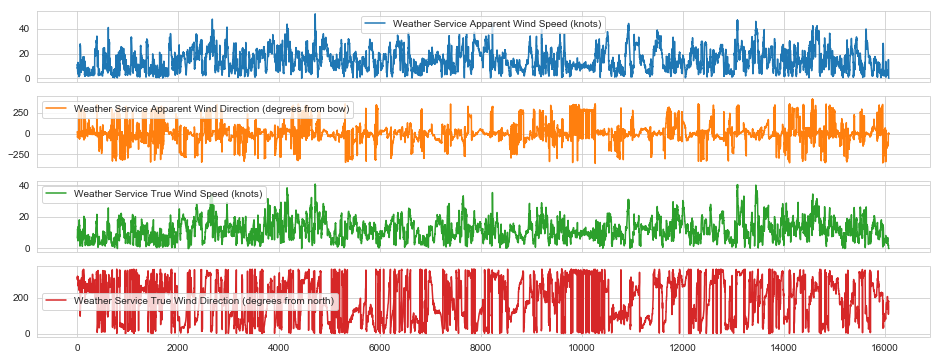

In [11]:
# Wind conditions
fig_wind, axes_wind = plt.subplots(len(cols_wind),1, figsize=(16,len(cols_wind)*1.5), sharex=True)
df_mod[cols_wind].plot(subplots=True, ax=axes_wind)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c23e04be0>,
      dtype=object)

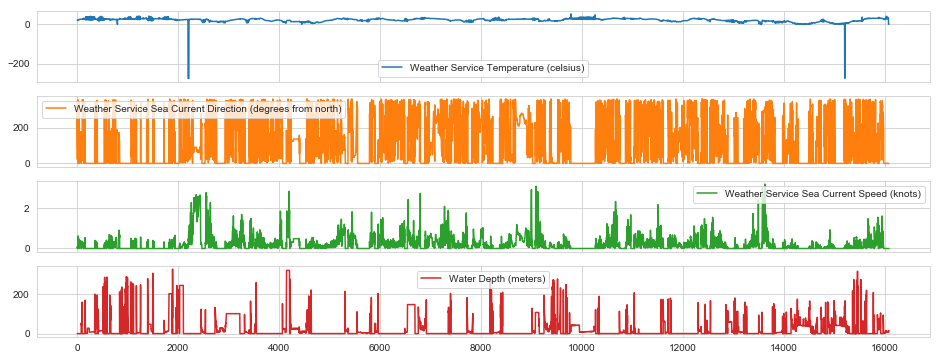

In [12]:
# Sea conditions
fig_sea, axes_sea = plt.subplots(len(cols_sea),1, figsize=(16,len(cols_sea)*1.5), sharex=True)
df_mod[cols_sea].plot(subplots=True, ax=axes_sea)

(16084, 23)

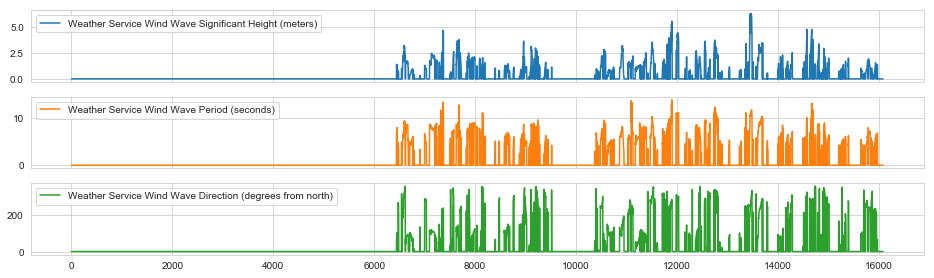

In [13]:
# Wave conditions
fig_wave, axes_wave = plt.subplots(len(cols_wave),1, figsize=(16,len(cols_wave)*1.5), sharex=True)
df_mod[cols_wave].plot(subplots=True, ax=axes_wave)

# Drop wave columns (too many missing records)
df_mod = df_mod.drop(cols_wave,axis=1)
df_mod.shape

# Data Cleaning

In [14]:
# Convert Unix time to datetime format
df_mod['Time'] = pd.to_datetime(df_mod['Time'], unit='s')
print(df_mod['Time'].head())

0   2017-07-06 13:15:00
1   2017-07-06 14:00:00
2   2017-07-06 15:00:00
3   2017-07-06 16:00:00
4   2017-07-06 17:00:00
Name: Time, dtype: datetime64[ns]


In [15]:
# Calibrate fuel consumption with most frequent near-zero measurement (-0.048 MT/day)
print(df_mod[cols_main[1]].value_counts().head())
df_mod[cols_main[1]] -= df_mod[cols_main[1]].value_counts().index[0]

# Drop records with negative fuel consumption ~ 16.2% of records
cutoff = 0.0
print('Percentage of records with negative consumption: ',
      df_mod[df_mod[cols_main[1]] < cutoff].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod[cols_main[1]] < cutoff].index)
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of remaining records:                 ', ((df_mod.shape[0] / n_records) * 100))

-0.048000     2105
-20.193103     829
-19.200000     617
-0.050483      526
 0.000000      149
Name: Main Engine Fuel Consumption (MT/day), dtype: int64
Percentage of records with negative consumption:  16.235844411619894
Percentage of remaining records:                  82.75480059084195


In [16]:
# Revert HFO and MGO to booleans (few partial-use records)
print(df_mod[cols_main[2]].value_counts())
df_mod[cols_main[2]] = df_mod[cols_main[2]].round(0).astype('int64')
df_mod[cols_main[3]] = df_mod[cols_main[3]].round(0).astype('int64')

# Check that only one fuel gauge is indicated at a time 
df_mod['Fuel Gauge'] = df_mod[cols_main[2]] + df_mod[cols_main[3]]
print(df_mod['Fuel Gauge'].value_counts())

# Drop records with neither HFO nor MGO indicator ~ 0.9% of records
print('Percentage of records with no fuel indicator: ',
      df_mod[df_mod['Fuel Gauge'] == 0].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod['Fuel Gauge'] == 0].index)
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of remaining records:              ', ((df_mod.shape[0] / n_records) * 100))

# Drop fuel gauge
df_mod = df_mod.drop(['Fuel Gauge'], axis=1)

1.000000    12456
0.000000      961
0.583333        4
0.083333        3
0.250000        3
0.666667        3
0.750000        2
0.083333        2
0.500000        2
0.166667        2
0.916667        1
0.833333        1
0.416667        1
0.833333        1
0.333333        1
0.583333        1
0.416667        1
0.333333        1
Name: Main Engine Using HFO (bool), dtype: int64
1    13294
0      152
Name: Fuel Gauge, dtype: int64
Percentage of records with no fuel indicator:  0.9354997538158543
Percentage of remaining records:               81.8193008370261


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2424e780>,
      dtype=object)

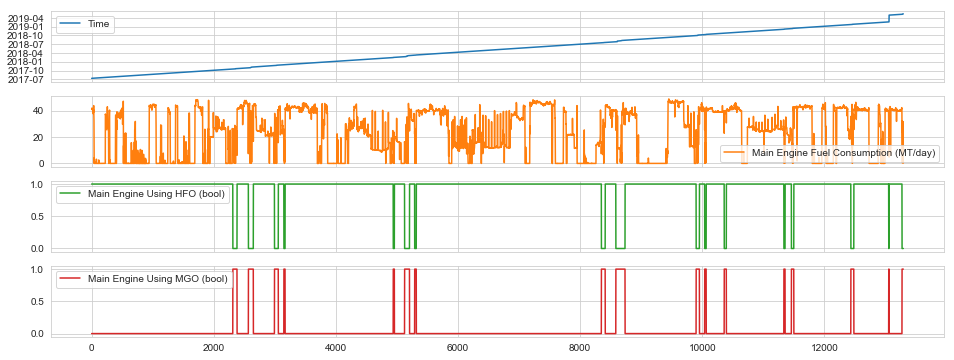

In [17]:
# Time and main engine (cleaned)
fig_main, axes_main = plt.subplots(len(cols_main),1, figsize=(16,len(cols_main)*1.5), sharex=True)
df_mod[cols_main].plot(subplots=True, ax=axes_main)

359.999195    1
359.998022    1
359.997018    1
359.996044    1
359.994729    1
Name: Rudder Angle (degrees), dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2461f0b8>],
      dtype=object)

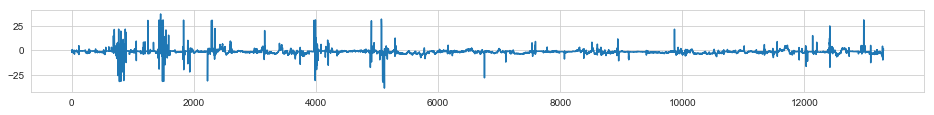

In [18]:
# Make rudder data continuous by using -180 to 180 degree angles
degrees = 360
print(df_mod[cols_speed[3]].value_counts().sort_index(ascending=False).head())
df_mod.loc[df_mod[cols_speed[3]] > 180, cols_speed[3]] -= degrees

# Rudder angle (cleaned)
fig_speed, axes_speed = plt.subplots(1,1, figsize=(16,1*1.5), sharex=True)
df_mod[cols_speed[3]].plot(subplots=True, ax=axes_speed)

-273.150000    18
-1.055194       1
 0.000000      17
 1.646941       1
 2.553591       1
Name: Weather Service Temperature (celsius), dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c24f70da0>],
      dtype=object)

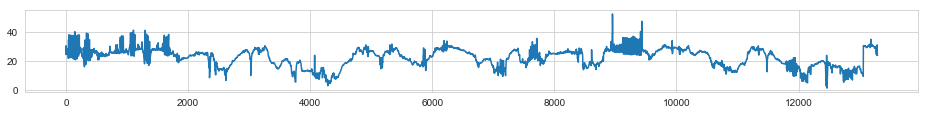

In [19]:
# Replace non-positive temperature records with median
print(df_mod[cols_sea[0]].value_counts().sort_index().head())
df_mod.loc[df_mod[cols_sea[0]] <= 0, cols_sea[0]] = df_mod[df_mod[cols_sea[0]] > 0][cols_sea[0]].median()

# Temperature (cleaned)
fig_sea, axes_sea = plt.subplots(1,1, figsize=(16,1*1.5), sharex=True)
df_mod[cols_sea[0]].plot(subplots=True, ax=axes_sea)

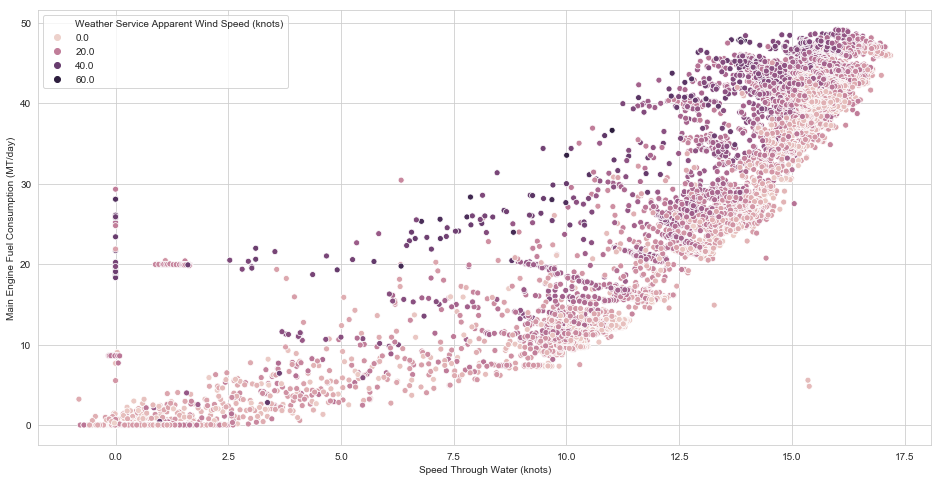

In [20]:
# Plot data after cleaning
plt.figure(figsize=(16,8))
sns.scatterplot(x    = 'Speed Through Water (knots)',
                y    = 'Main Engine Fuel Consumption (MT/day)',
                hue  = 'Weather Service Apparent Wind Speed (knots)',
                data = df_mod)

# Feature Engineering

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c25e959e8>,
      dtype=object)

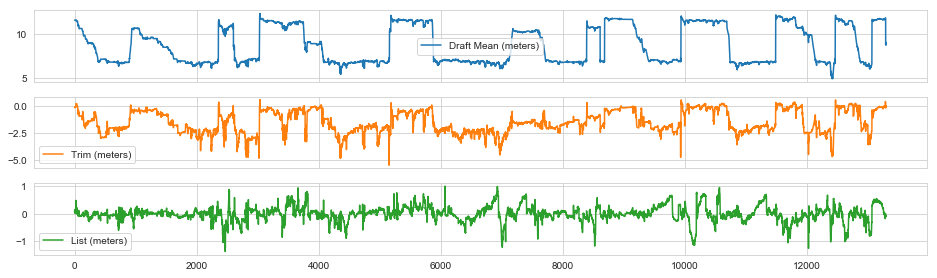

In [21]:
# Engineer features for mean draft, trim (aft heavy) and list
df_mod['Draft Mean (meters)'] = df_mod[cols_draft].mean(axis=1)
df_mod['Trim (meters)']       = df_mod[cols_draft[0]] - df_mod[cols_draft[1]]
df_mod['List (meters)']       = df_mod[cols_draft[2]] - df_mod[cols_draft[3]]

# Plot time series
fig_draft, axes_draft = plt.subplots(3,1, figsize=(16,3*1.5), sharex=True)
df_mod[['Draft Mean (meters)',
        'Trim (meters)',
        'List (meters)']].plot(subplots=True, ax=axes_draft)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c257ee828>],
      dtype=object)

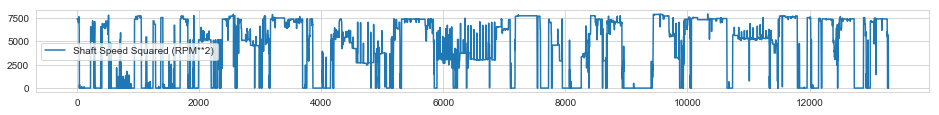

In [22]:
# Engineer features for quadratic term of shaft speed
df_mod['Shaft Speed Squared (RPM**2)'] = df_mod['Shaft Speed (RPM)'] ** 2

# Plot time series
fig_shaft, axes_shaft = plt.subplots(1,1, figsize=(16,1*1.5), sharex=True)
df_mod[['Shaft Speed Squared (RPM**2)']].plot(subplots=True, ax=axes_shaft)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c26e1e358>],
      dtype=object)

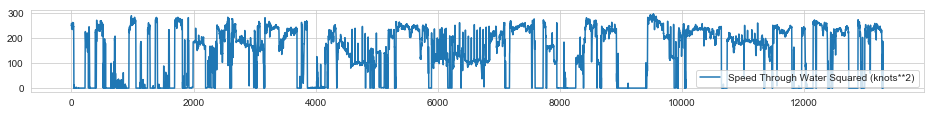

In [23]:
# Engineer features for quadratic term of speed through water
df_mod['Speed Through Water Squared (knots**2)'] = df_mod['Speed Through Water (knots)'] ** 2

# Plot time series
fig_speed, axes_speed = plt.subplots(1,1, figsize=(16,1*1.5), sharex=True)
df_mod[['Speed Through Water Squared (knots**2)']].plot(subplots=True, ax=axes_speed)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c26691208>,
      dtype=object)

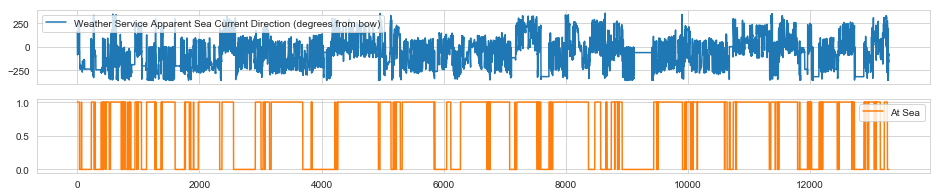

In [24]:
# Engineer features for apparent sea current direction and speed
col         = 'Weather Service Apparent Sea Current Direction (degrees from bow)'
df_mod[col] = df_mod[cols_sea[1]] - df_mod[cols_speed[2]]

# Engineer at-sea vs in-port from water depth
df_mod['At Sea'] = np.where(df_mod[cols_sea[3]]==0.0, 1, 0)

# Plot time series
fig_sea, axes_sea = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
df_mod[['Weather Service Apparent Sea Current Direction (degrees from bow)',
        'At Sea']].plot(subplots=True, ax=axes_sea)

# Exploratory Data Analysis

Main Engine Fuel Consumption (MT/day)                                1.000000
Shaft Power (kW)                                                     0.996606
Shaft Torque (kNm)                                                   0.988665
Shaft Speed Squared (RPM**2)                                         0.987008
Speed Through Water Squared (knots**2)                               0.963057
Shaft Speed (RPM)                                                    0.943000
Speed Through Water (knots)                                          0.927595
Speed Over Ground (knots)                                            0.927171
At Sea                                                               0.460948
Weather Service Apparent Wind Speed (knots)                          0.458996
Draft Aft (meters)                                                   0.421537
Weather Service Sea Current Direction (degrees from north)           0.404787
Draft Mean (meters)                                             

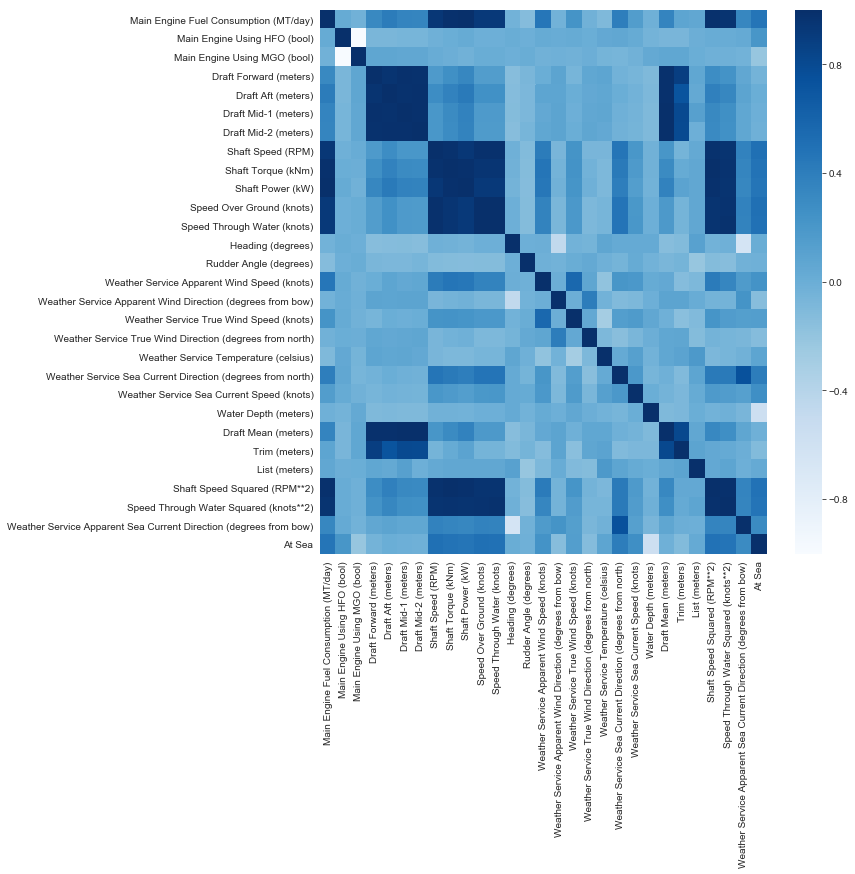

In [25]:
# Investigate multi-collinearity of variables
fig = plt.figure(figsize=(10,10))
corr = df_mod.corr()
sns.heatmap(corr, cmap="Blues")

# Print correlation coefficients of dependent variables to target
corr[cols_main[1]].sort_values(ascending=False)

Main Engine Fuel Consumption (MT/day)  Main Engine Using HFO (bool)  \
count                           13294.000000                  13294.000000   
mean                               23.088197                      0.937942   
std                                17.431775                      0.241270   
min                                 0.000000                      0.000000   
25%                                 0.201277                      1.000000   
50%                                25.125368                      1.000000   
75%                                40.672698                      1.000000   
max                                49.138823                      1.000000   

       Main Engine Using MGO (bool)  
count                  13294.000000  
mean                       0.062058  
std                        0.241270  
min                        0.000000  
25%                        0.000000  
50%                        0.000000  
75%                        0.000000  
max                        1.000000

<Figure size 432x216 with 0 Axes>

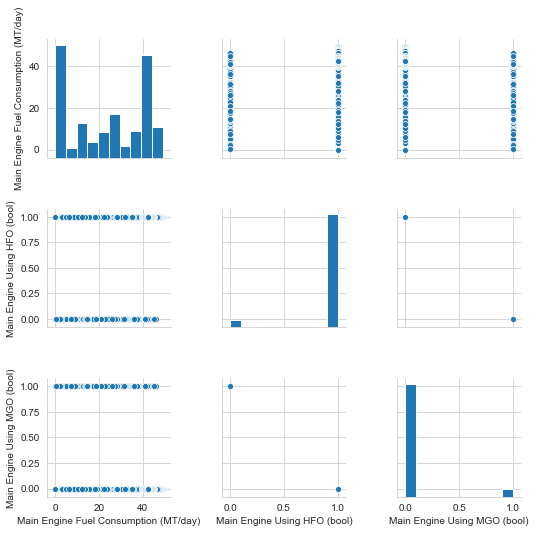

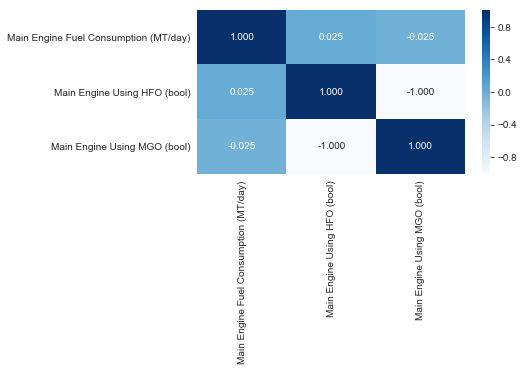

In [26]:
# Time and main engine pair plots
fig = plt.figure(figsize=(6,3))
sns.pairplot(df_mod[cols_main])

# Investigate multi-collinearity of main sensors
fig       = plt.figure(figsize=(6,3))
corr_main = df_mod[cols_main].corr()
sns.heatmap(corr_main, annot=True, fmt=".3f", cmap="Blues")

# Statistics
df_mod[cols_main].describe()

Main Engine Fuel Consumption (MT/day)  \
Fuel                                                           
Main Engine Using HFO                              30.257497   
Main Engine Using MGO                              20.660725   

                       Main Engine Using HFO (bool)  \
Fuel                                                  
Main Engine Using HFO                             1   
Main Engine Using MGO                             0   

                       Main Engine Using MGO (bool)  
Fuel                                                 
Main Engine Using HFO                             0  
Main Engine Using MGO                             1

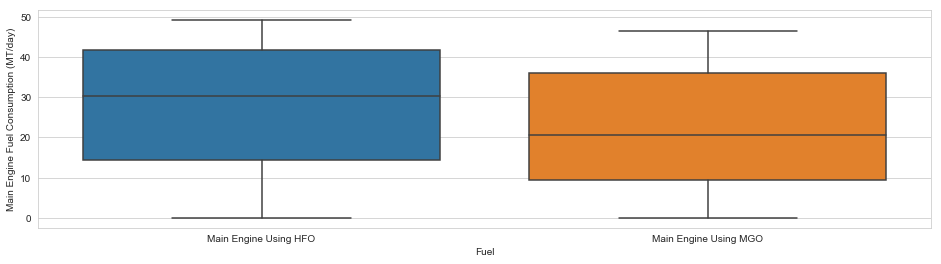

In [27]:
# Explore fuel consumption by fuel source
df_hfo = df_mod[df_mod[cols_main[2]] == 1].copy()
df_hfo['Fuel'] = 'Main Engine Using HFO'

df_mgo = df_mod[df_mod[cols_main[3]] == 1].copy()
df_mgo['Fuel'] = 'Main Engine Using MGO'

# Drop records with zero fuel consumption (for EDA only)
df_fuel = pd.concat([df_hfo, df_mgo])
df_fuel = df_fuel[df_fuel[cols_main[1]] > 0]

# Plot fuel consumption by fuel source
plt.figure('Fuel Source', figsize=(16,4))
sns.boxplot(x='Fuel', y=cols_main[1], data=df_fuel)

# Print median fuel consumption by fuel source
df_fuel.groupby('Fuel')[cols_main].median()

Draft Forward (meters)  Draft Aft (meters)  Draft Mid-1 (meters)  \
count            13294.000000        13294.000000          13294.000000   
mean                 7.998504            9.512124              8.751299   
std                  2.566563            1.727537              2.115794   
min                  1.761927            6.477834              5.264249   
25%                  5.761688            7.933613              6.811051   
50%                  6.851848            8.736326              7.675043   
75%                 10.754630           11.498797             11.165957   
max                 13.136587           12.589208             12.076237   

       Draft Mid-2 (meters)  
count          13294.000000  
mean               8.765571  
std                2.100942  
min                5.681231  
25%                6.836185  
50%                7.682327  
75%               11.170656  
max               12.127948

<Figure size 432x216 with 0 Axes>

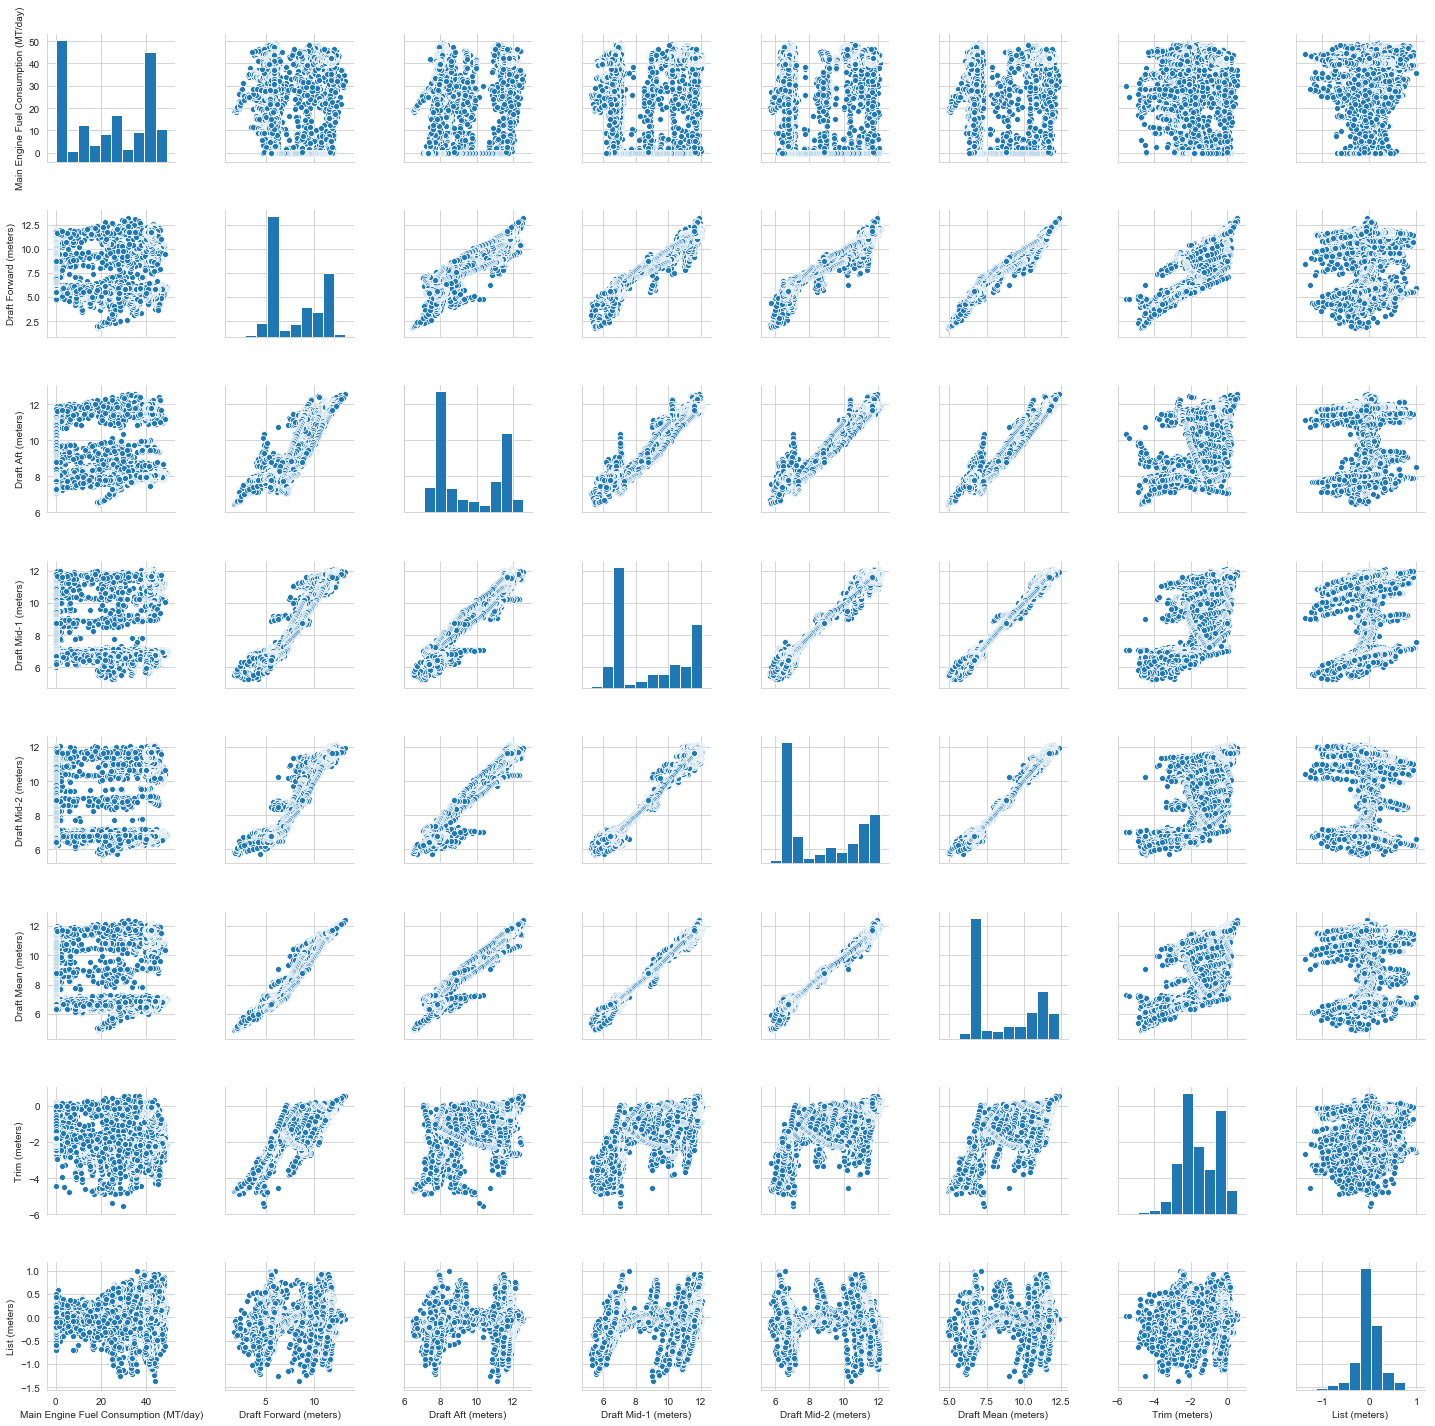

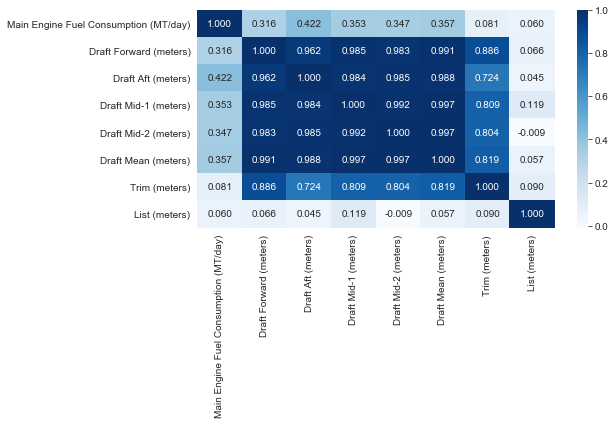

In [28]:
# Draft sensor pair plots
fig  = plt.figure(figsize=(6,3))
cols = [cols_main[1]] + list(cols_draft) + ['Draft Mean (meters)','Trim (meters)','List (meters)']
sns.pairplot(df_mod[cols])

# Investigate multi-collinearity of draft sensors
fig        = plt.figure(figsize=(8,4))
corr_draft = df_mod[cols].corr()
sns.heatmap(corr_draft, annot=True, fmt=".3f", cmap="Blues")

# Statistics
df_mod[cols_draft].describe()

Main Engine Fuel Consumption (MT/day)  Shaft Speed (RPM)  \
count                           13294.000000       13294.000000   
mean                               23.088197          54.767804   
std                                17.431775          35.363715   
min                                 0.000000          -7.110332   
25%                                 0.201277           0.000000   
50%                                25.125368          71.773562   
75%                                40.672698          85.696325   
max                                49.138823          88.959431   

       Shaft Torque (kNm)  Shaft Power (kW)  Shaft Speed Squared (RPM**2)  
count        13294.000000      13294.000000                  13294.000000  
mean           621.972953       5179.079963                   4250.010597  
std            435.562025       4004.406412                   3044.810421  
min             -0.000460          5.276229                      0.000000  
25%             12.027868          7.960926                      0.000545  
50%            745.846497       5630.125342                   5151.444168  
75%           1038.392816       9315.960332                   7343.860196  
max           1206.091541      11150.041983                   7913.780288

<Figure size 432x216 with 0 Axes>

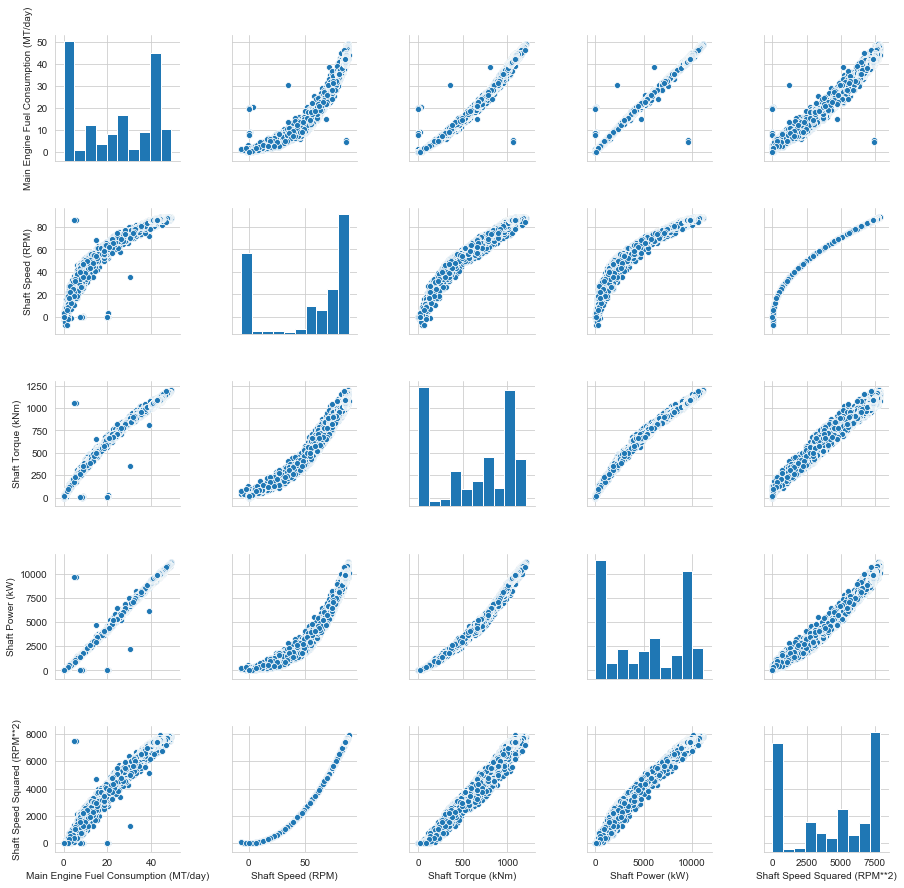

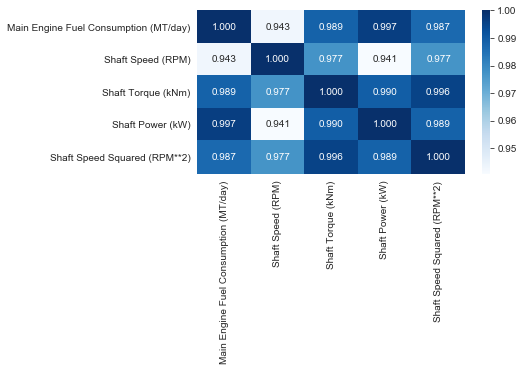

In [29]:
# Shaft performance pair plots
fig  = plt.figure(figsize=(6,3))
cols = [cols_main[1]] + list(cols_shaft) + ['Shaft Speed Squared (RPM**2)']
sns.pairplot(df_mod[cols])

# Investigate multi-collinearity of shaft sensors (Power = Speed x Torque x unit conversion)
fig        = plt.figure(figsize=(6,3))
corr_shaft = df_mod[cols].corr()
sns.heatmap(corr_shaft, annot=True, fmt=".3f", cmap="Blues")

# Statistics
df_mod[cols].describe()

Speed Over Ground (knots)  Speed Through Water (knots)  \
count               13294.000000                 13294.000000   
mean                   10.055001                     9.953996   
std                     6.314415                     6.320701   
min                     0.000000                    -0.812132   
25%                     1.807973                     1.325097   
50%                    13.044746                    13.059407   
75%                    15.263638                    15.232244   
max                    19.844884                    17.186902   

       Heading (degrees)  Rudder Angle (degrees)  
count       13294.000000            13294.000000  
mean          189.708437               -1.254819  
std           101.726415                3.393461  
min             0.123706              -37.916252  
25%            90.143655               -2.054992  
50%           225.322315               -1.242882  
75%           277.797905               -0.682076  
max           359.824424               36.801810

<Figure size 432x216 with 0 Axes>

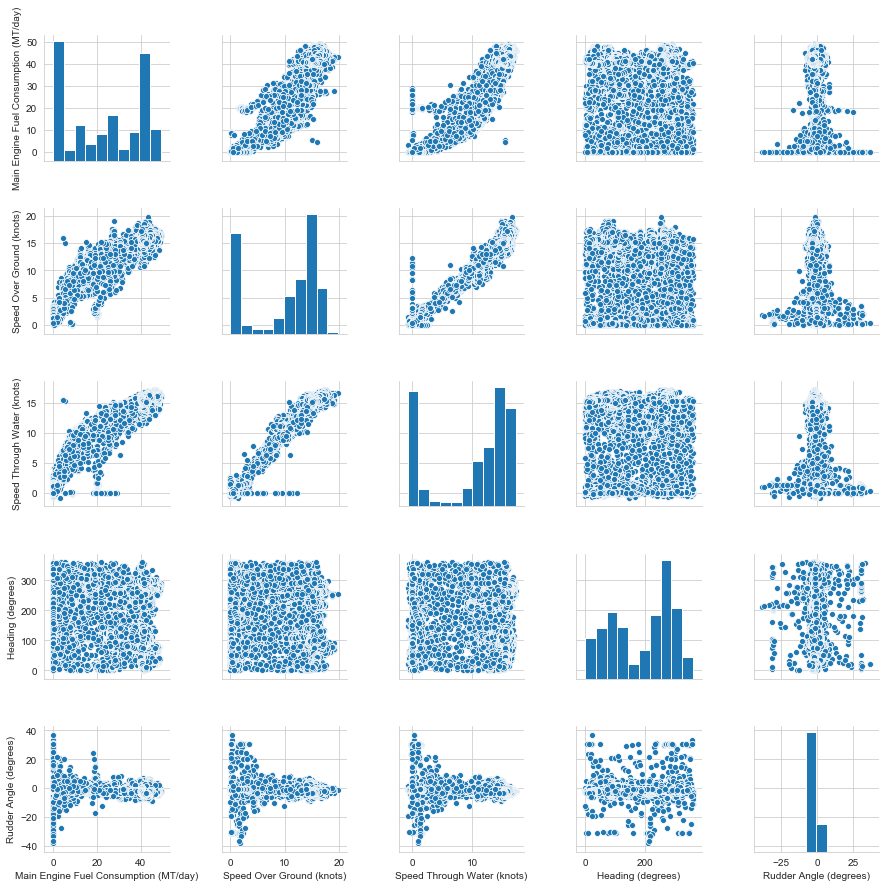

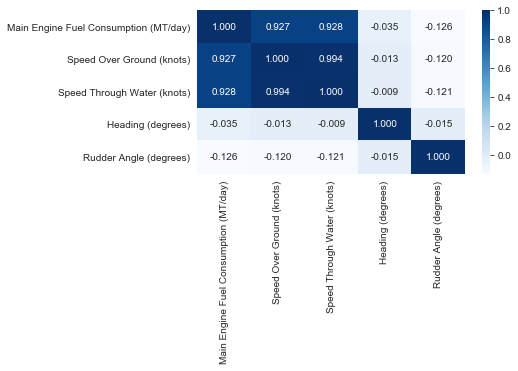

In [30]:
# Vessel speed pair plots
fig  = plt.figure(figsize=(6,3))
cols = [cols_main[1]] + list(cols_speed)
sns.pairplot(df_mod[cols])

# Investigate multi-collinearity of speed and heading sensors
fig        = plt.figure(figsize=(6,3))
corr_speed = df_mod[cols].corr()
sns.heatmap(corr_speed, annot=True, fmt=".3f", cmap="Blues")

# Statistics
df_mod[cols_speed].describe()

Weather Service Apparent Wind Speed (knots)  \
count                                 13294.000000   
mean                                     15.038842   
std                                       8.649540   
min                                       0.000000   
25%                                       8.314335   
50%                                      13.822674   
75%                                      20.802552   
max                                      51.955335   

       Weather Service Apparent Wind Direction (degrees from bow)  \
count                                       13294.000000            
mean                                            1.773545            
std                                           113.749803            
min                                          -358.561592            
25%                                           -41.250026            
50%                                            -2.358334            
75%                                            35.728403            
max                                           358.000339            

       Weather Service True Wind Speed (knots)  \
count                             13294.000000   
mean                                 12.024931   
std                                   6.450350   
min                                   0.000000   
25%                                   7.314592   
50%                                  11.359357   
75%                                  15.994612   
max                                  40.845838   

       Weather Service True Wind Direction (degrees from north)  
count                                       13294.000000         
mean                                          188.159086         
std                                           114.740370         
min                                             0.000568         
25%                                            77.182397         
50%                                           201.647541         
75%                                           295.228736         
max                                           359.997076

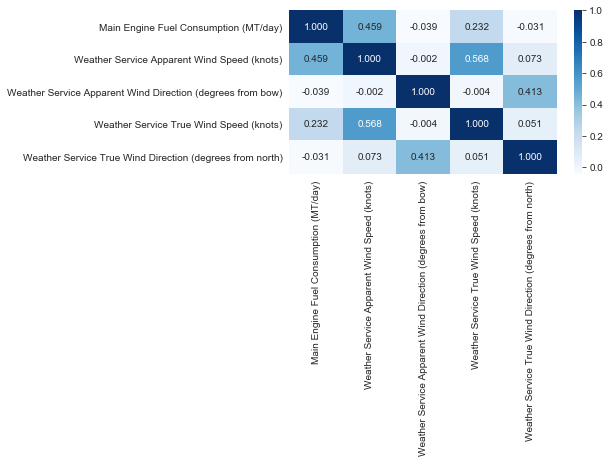

In [31]:
# Investigate multi-collinearity of wind sensors
fig       = plt.figure(figsize=(6,3))
cols      = [cols_main[1]] + list(cols_wind)
corr_wind = df_mod[cols].corr()
sns.heatmap(corr_wind, annot=True, fmt=".3f", cmap="Blues")

# Statistics
df_mod[cols_wind].describe()

Weather Service Temperature (celsius)  \
count                           13294.000000   
mean                               22.597054   
std                                 6.345735   
min                                 1.646941   
25%                                18.369530   
50%                                24.121217   
75%                                27.173381   
max                                52.559168   

       Weather Service Sea Current Direction (degrees from north)  \
count                                       13294.000000            
mean                                          125.063068            
std                                           116.041048            
min                                             0.000000            
25%                                             0.000000            
50%                                           101.412659            
75%                                           224.488252            
max                                           359.999716            

       Weather Service Sea Current Speed (knots)  Water Depth (meters)  
count                               13294.000000          13294.000000  
mean                                    0.292205             19.292376  
std                                     0.416830             47.640937  
min                                     0.000000              0.000000  
25%                                     0.000000              0.000000  
50%                                     0.159163              0.000000  
75%                                     0.382378              8.999632  
max                                     3.184603            326.803230

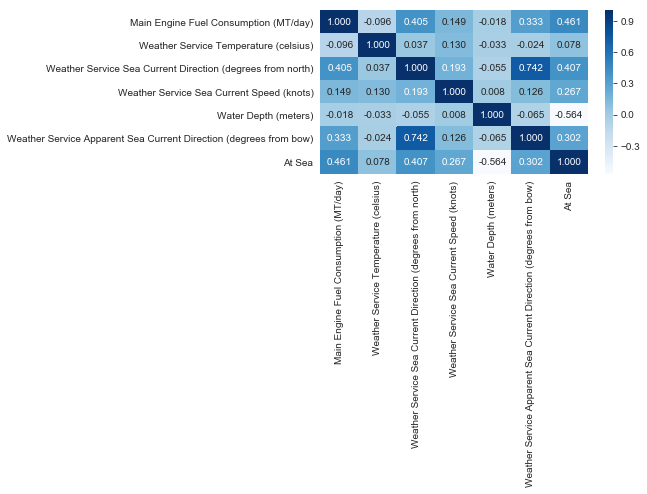

In [32]:
# Investigate multi-collinearity of sea sensors
fig      = plt.figure(figsize=(6,3))
cols     = [cols_main[1]] + list(cols_sea) + [
    'Weather Service Apparent Sea Current Direction (degrees from bow)','At Sea']
corr_sea = df_mod[cols].corr()
sns.heatmap(corr_sea, annot=True, fmt=".3f", cmap="Blues")

# Statistics
df_mod[cols_sea].describe()

# Outliers

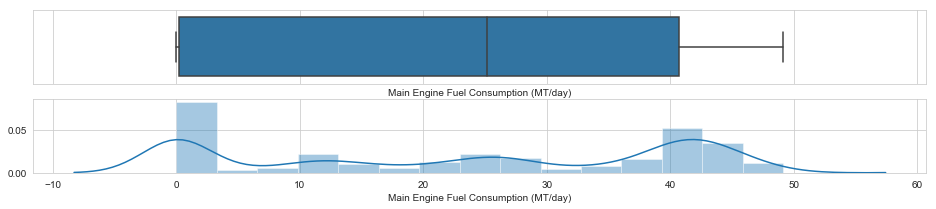

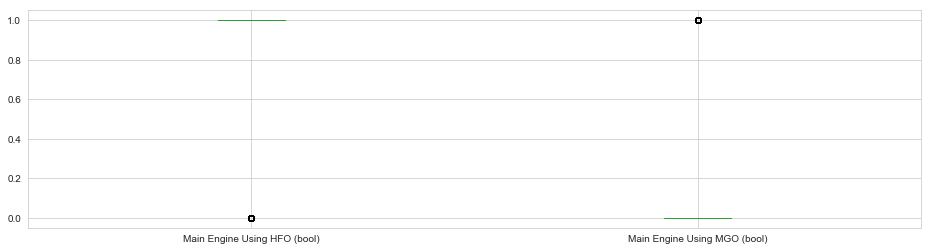

In [33]:
# Main engine fuel consumption
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_main[1]], ax=ax_box)
sns.distplot(df_mod[cols_main[1]], ax=ax_hist)

# Fuel source
plt.figure("Boxplot", figsize=(16,4))
df_mod[cols_main[2:4]].boxplot()

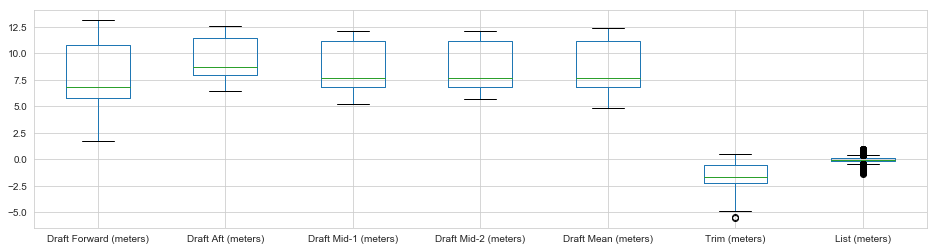

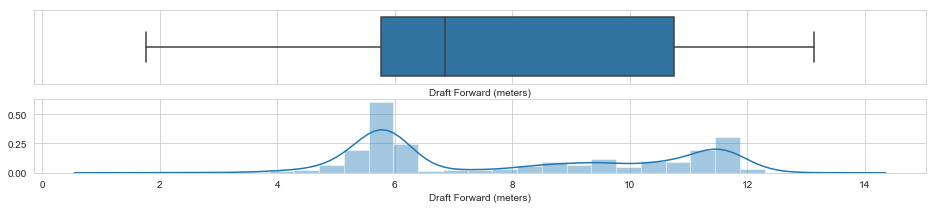

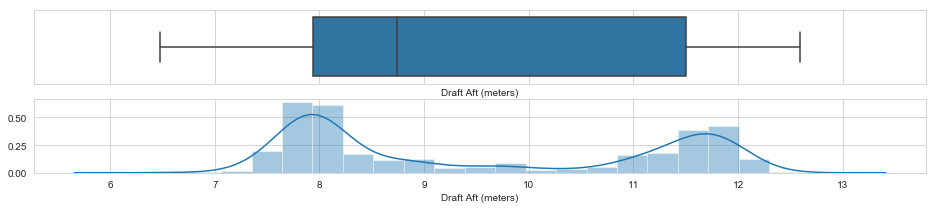

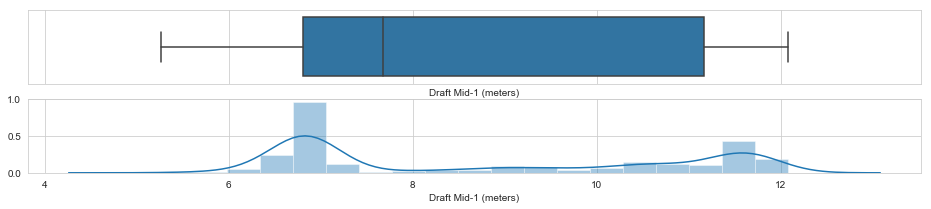

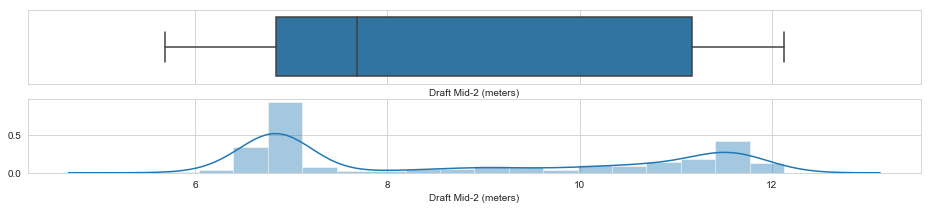

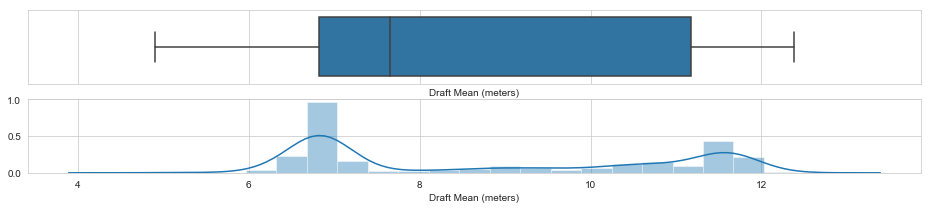

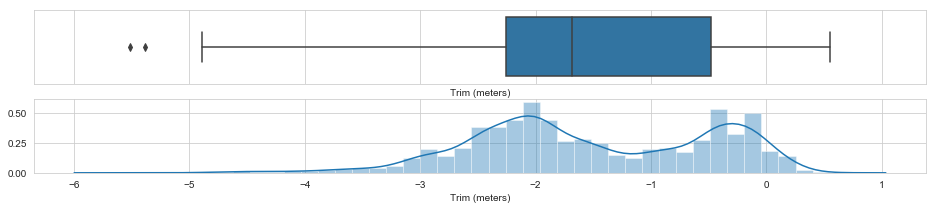

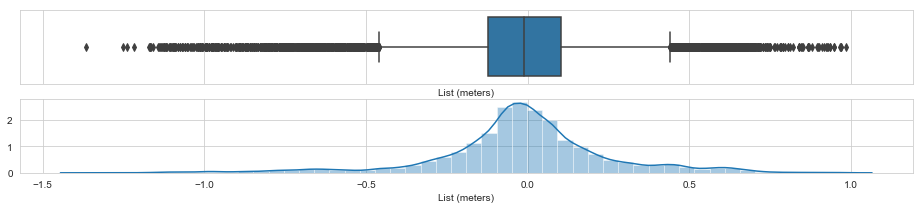

In [34]:
# Draft sensors
plt.figure("Boxplot", figsize=(16,4))
cols = list(cols_draft) + ['Draft Mean (meters)','Trim (meters)','List (meters)']
df_mod[cols].boxplot()

# Forward draft sensor
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_draft[0]], ax=ax_box)
sns.distplot(df_mod[cols_draft[0]], ax=ax_hist)

# Aft draft sensor
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_draft[1]], ax=ax_box)
sns.distplot(df_mod[cols_draft[1]], ax=ax_hist)

# Mid-1 draft sensor
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_draft[2]], ax=ax_box)
sns.distplot(df_mod[cols_draft[2]], ax=ax_hist)

# Mid-2 draft sensor
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_draft[3]], ax=ax_box)
sns.distplot(df_mod[cols_draft[3]], ax=ax_hist)

# Draft mean
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod['Draft Mean (meters)'], ax=ax_box)
sns.distplot(df_mod['Draft Mean (meters)'], ax=ax_hist)

# Trim
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod['Trim (meters)'], ax=ax_box)
sns.distplot(df_mod['Trim (meters)'], ax=ax_hist)

# List
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod['List (meters)'], ax=ax_box)
sns.distplot(df_mod['List (meters)'], ax=ax_hist)

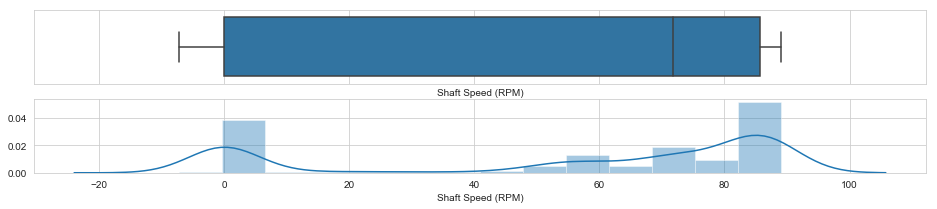

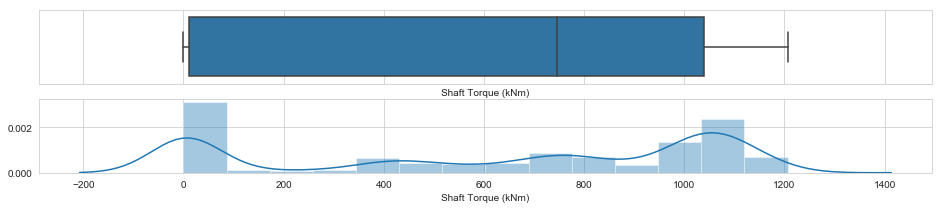

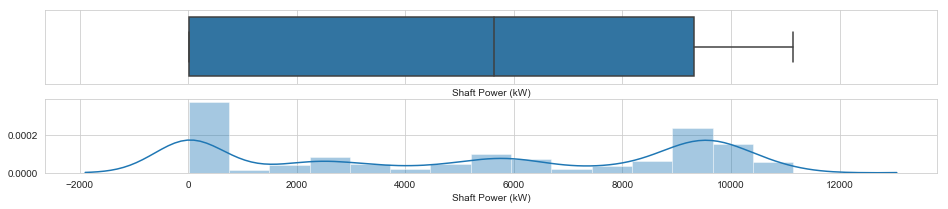

In [35]:
# Shaft speed
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_shaft[0]], ax=ax_box)
sns.distplot(df_mod[cols_shaft[0]], ax=ax_hist)

# Shaft torque
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_shaft[1]], ax=ax_box)
sns.distplot(df_mod[cols_shaft[1]], ax=ax_hist)

# Shaft power
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_shaft[2]], ax=ax_box)
sns.distplot(df_mod[cols_shaft[2]], ax=ax_hist)

Percentage of zero shaft speed records:      7.440915805022157
Percentage of remaining records:              74.37838503200393
Percentage of high speed / low fuel records:  0.012309207287050716
Percentage of remaining records:              74.36607582471689
Percentage of low speed / high fuel records:  0.01846381093057607
Percentage of remaining records:              74.34761201378632


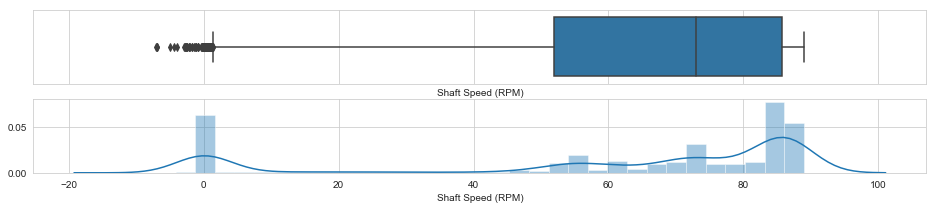

In [36]:
# Drop records with 0.0 shaft speed that simultaneously consume power ~ 7.4% of records
cutoff = 0.0
print('Percentage of zero shaft speed records:     ',
      df_mod[(df_mod[cols_shaft[0]] == cutoff) & (df_mod[cols_main[1]] != cutoff)].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[(df_mod[cols_shaft[0]] == cutoff) & (df_mod[cols_main[1]] != cutoff)].index)
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of remaining records:             ', ((df_mod.shape[0] / n_records) * 100))

# Drop records with > 85 shaft speed and < 6 MT/day consumption ~ 0.01% of records
print('Percentage of high speed / low fuel records: ',
      df_mod[(df_mod[cols_main[1]] < 6) & (df_mod[cols_shaft[0]] > 85)].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[(df_mod[cols_main[1]] < 6) & (df_mod[cols_shaft[0]] > 85)].index)
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of remaining records:             ', ((df_mod.shape[0] / n_records) * 100))

# Drop records with < 40 shaft speed and > 20 MT/day consumption ~ 0.02% of records
print('Percentage of low speed / high fuel records: ',
      df_mod[(df_mod[cols_main[1]] > 20) & (df_mod[cols_shaft[0]] < 40)].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[(df_mod[cols_main[1]] > 20) & (df_mod[cols_shaft[0]] < 40)].index)
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of remaining records:             ', ((df_mod.shape[0] / n_records) * 100))

# Shaft speed
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_shaft[0]], ax=ax_box)
sns.distplot(df_mod[cols_shaft[0]], ax=ax_hist)

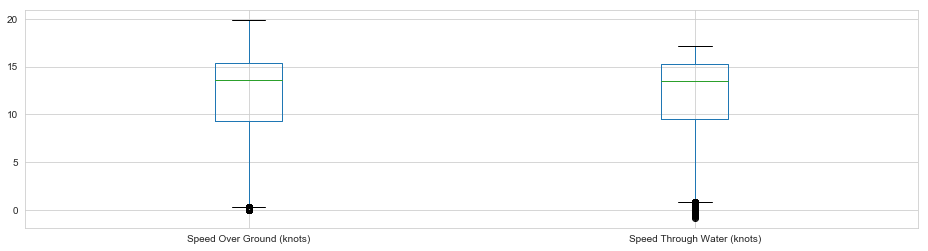

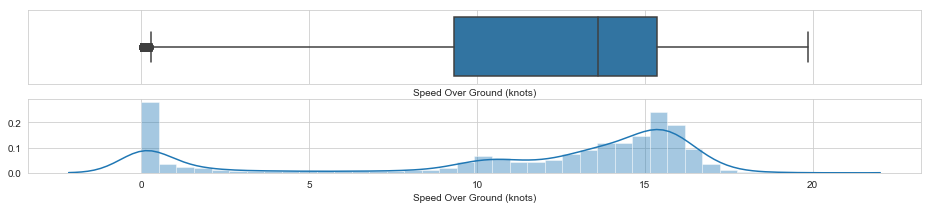

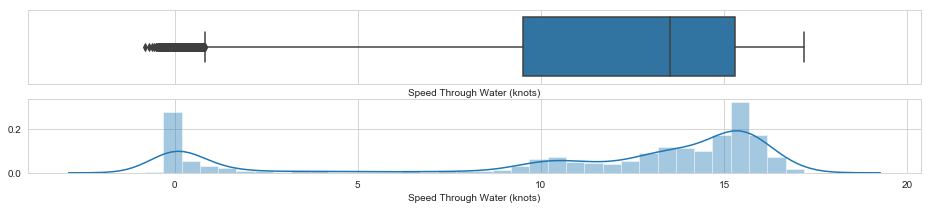

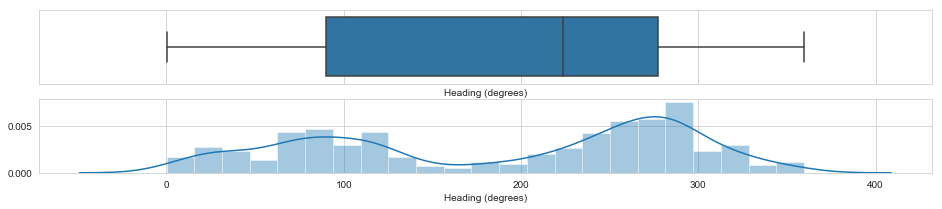

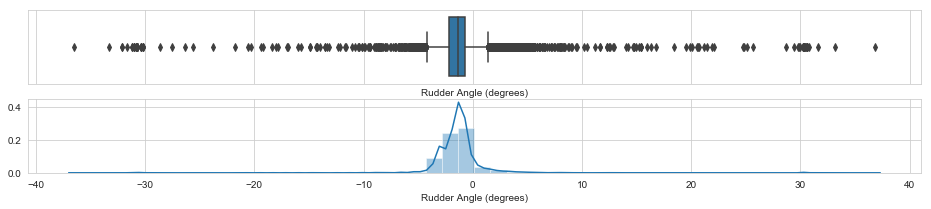

In [37]:
# Vessel speed
plt.figure("Boxplot", figsize=(16,4))
df_mod[cols_speed[0:2]].boxplot()

# Speed over ground
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[0]], ax=ax_box)
sns.distplot(df_mod[cols_speed[0]], ax=ax_hist)

# Speed through water
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[1]], ax=ax_box)
sns.distplot(df_mod[cols_speed[1]], ax=ax_hist)

# Heading angle
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[2]], ax=ax_box)
sns.distplot(df_mod[cols_speed[2]], ax=ax_hist)

# Rudder angle
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[3]], ax=ax_box)
sns.distplot(df_mod[cols_speed[3]], ax=ax_hist)

Percentage of zero speed through water records:  0.1846381093057607
Percentage of remaining records:             74.16297390448055


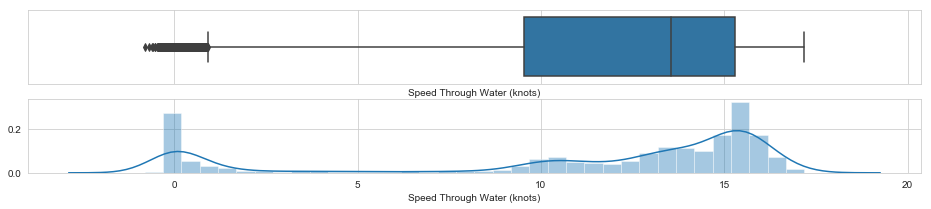

In [38]:
# Drop records with 0.0 speed through water that simultaneously consume power ~ 0.2% of records
cutoff = 0.0
print('Percentage of zero speed through water records: ',
      df_mod[(df_mod[cols_speed[1]] == cutoff) & (df_mod[cols_main[1]] != cutoff)].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[(df_mod[cols_speed[1]] == cutoff) & (df_mod[cols_main[1]] != cutoff)].index)
df_mod = df_mod.reset_index().drop('index',axis=1)
print('Percentage of remaining records:            ', ((df_mod.shape[0] / n_records) * 100))

# Speed through water
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_speed[1]], ax=ax_box)
sns.distplot(df_mod[cols_speed[1]], ax=ax_hist)

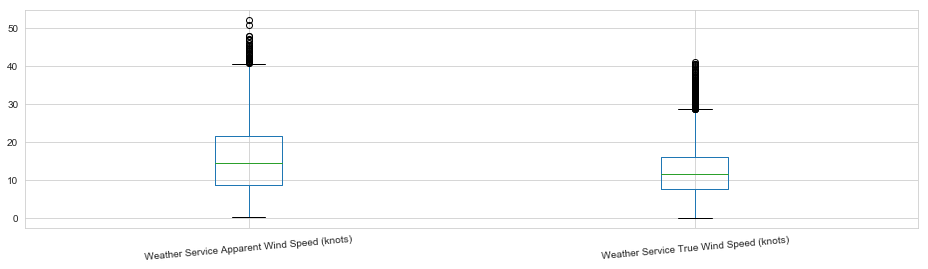

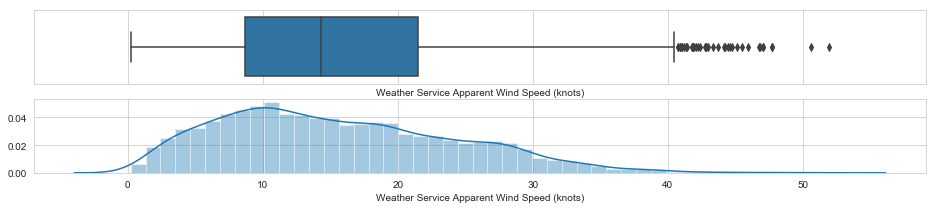

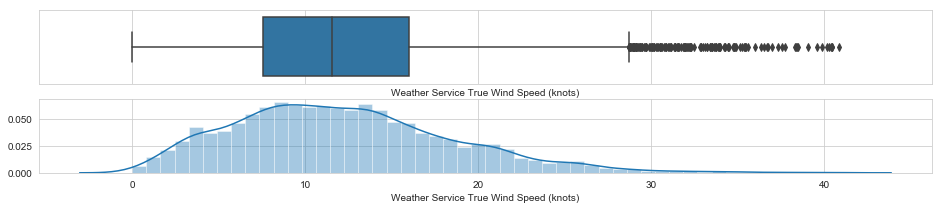

In [39]:
# Wind speed
plt.figure("Boxplot", figsize=(16,4))
df_mod[[cols_wind[0],cols_wind[2]]].boxplot()
plt.xticks(rotation=5)

# Apparent wind speed
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_wind[0]], ax=ax_box)
sns.distplot(df_mod[cols_wind[0]], ax=ax_hist)

# True wind speed
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_wind[2]], ax=ax_box)
sns.distplot(df_mod[cols_wind[2]], ax=ax_hist)

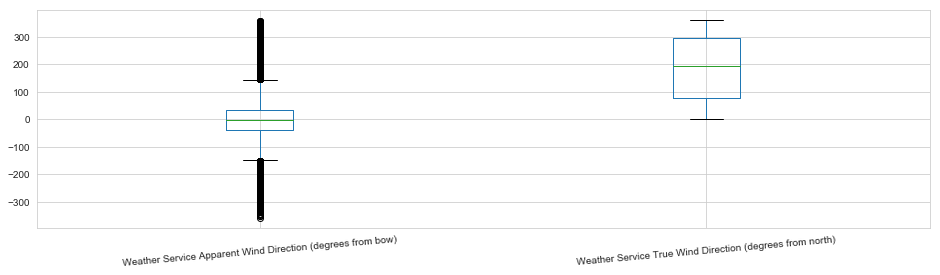

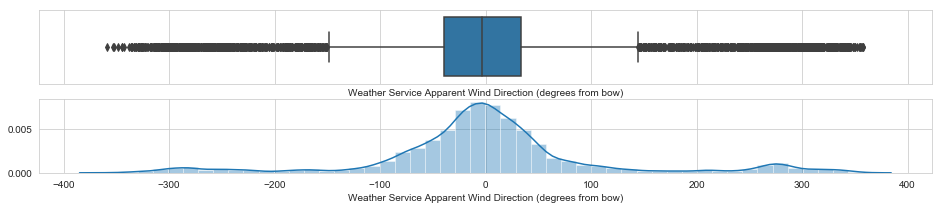

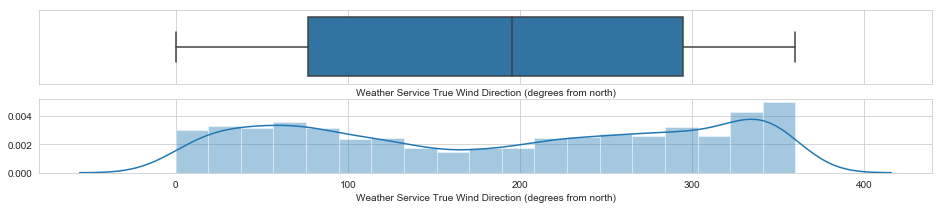

In [40]:
# Wind direction
plt.figure("Boxplot", figsize=(16,4))
df_mod[[cols_wind[1],cols_wind[3]]].boxplot()
plt.xticks(rotation=5)

# Apparent wind direction
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_wind[1]], ax=ax_box)
sns.distplot(df_mod[cols_wind[1]], ax=ax_hist)

# True wind direction
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_wind[3]], ax=ax_box)
sns.distplot(df_mod[cols_wind[3]], ax=ax_hist)

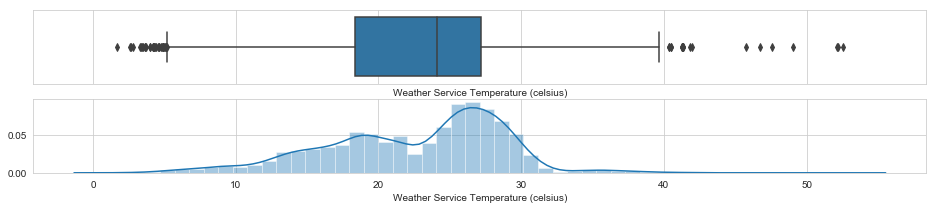

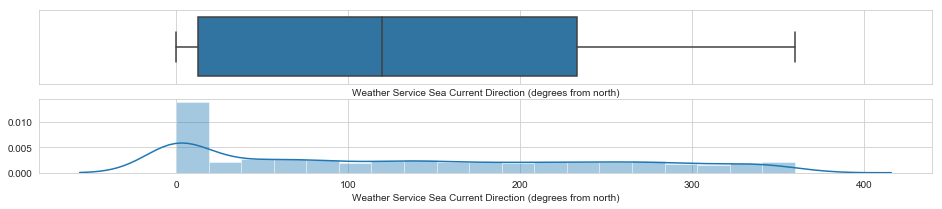

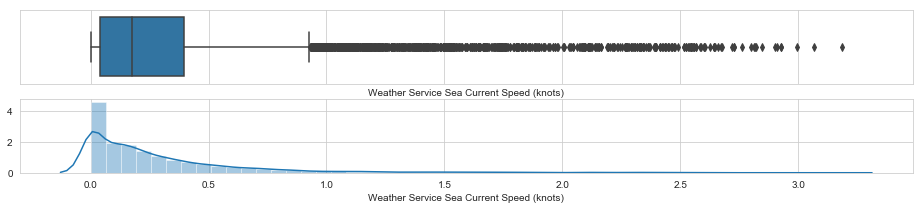

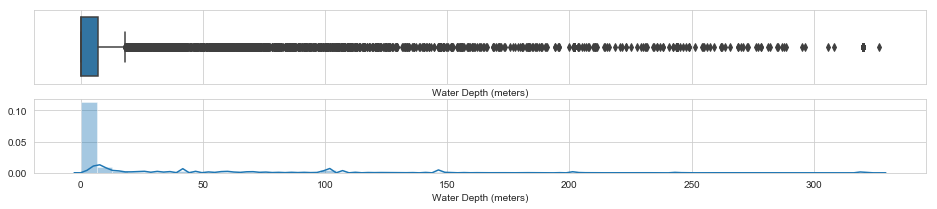

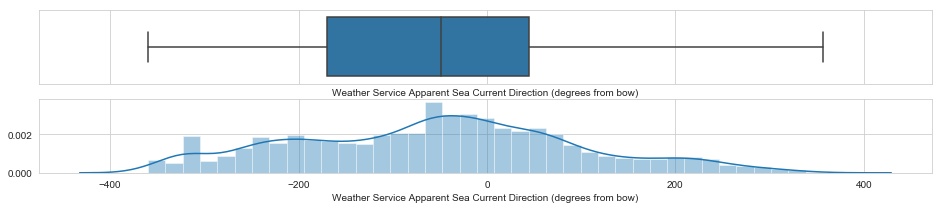

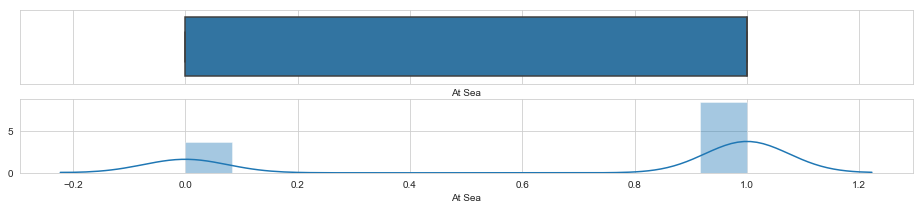

In [41]:
# Sea temperature
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_sea[0]], ax=ax_box)
sns.distplot(df_mod[cols_sea[0]], ax=ax_hist)

# Sea current direction
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_sea[1]], ax=ax_box)
sns.distplot(df_mod[cols_sea[1]], ax=ax_hist)

# Sea current speed
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_sea[2]], ax=ax_box)
sns.distplot(df_mod[cols_sea[2]], ax=ax_hist)

# Sea water depth
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod[cols_sea[3]], ax=ax_box)
sns.distplot(df_mod[cols_sea[3]], ax=ax_hist)

# Apparent sea current direction
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod['Weather Service Apparent Sea Current Direction (degrees from bow)'], ax=ax_box)
sns.distplot(df_mod['Weather Service Apparent Sea Current Direction (degrees from bow)'], ax=ax_hist)

# At sea
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_mod['At Sea'], ax=ax_box)
sns.distplot(df_mod['At Sea'], ax=ax_hist)

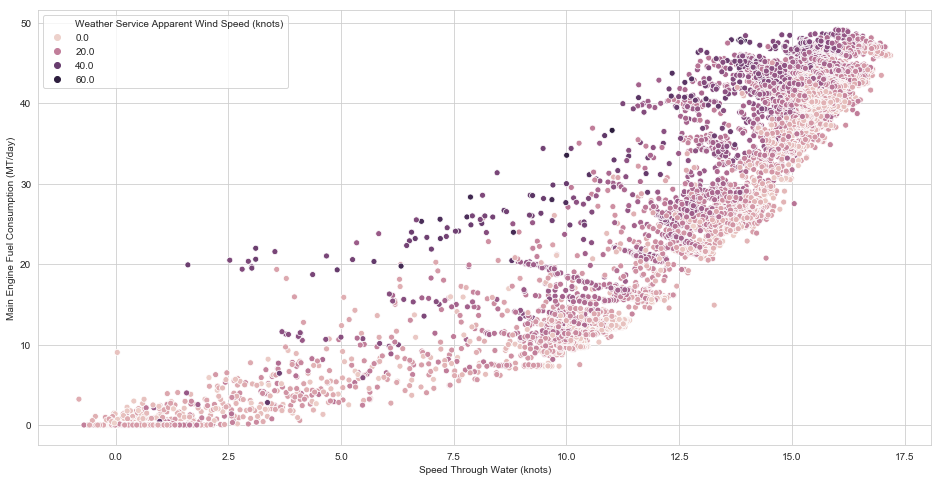

In [42]:
# Plot data after cleaning and outlier removal
plt.figure(figsize=(16,8))
sns.scatterplot(x    = 'Speed Through Water (knots)',
                y    = 'Main Engine Fuel Consumption (MT/day)',
                hue  = 'Weather Service Apparent Wind Speed (knots)',
                data = df_mod)

# Feature Selection

In [43]:
# Select features for linear regression model
df_feat = df_mod[['Main Engine Fuel Consumption (MT/day)',
                  'Draft Mean (meters)',
                  'Trim (meters)',
                  'Speed Through Water (knots)',
                  'Speed Through Water Squared (knots**2)',
                  'Weather Service Apparent Wind Speed (knots)',
                  'Weather Service Sea Current Speed (knots)']]

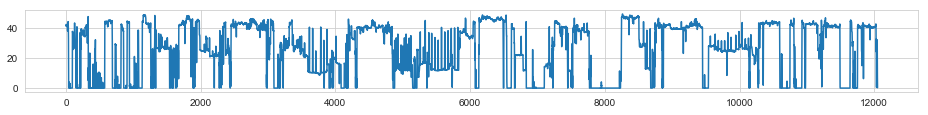

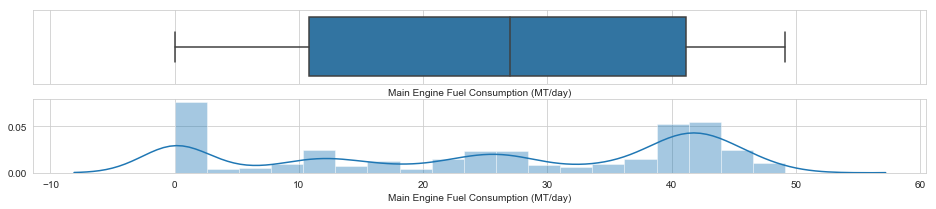

In [44]:
# Main engine fuel consumption
feat = 'Main Engine Fuel Consumption (MT/day)'

plt.subplots(figsize=(16,1.5))
df_feat[feat].plot()

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_feat[feat], ax=ax_box)
sns.distplot(df_feat[feat], ax=ax_hist)

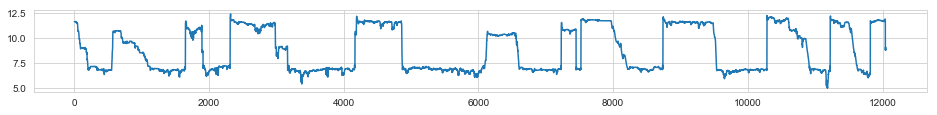

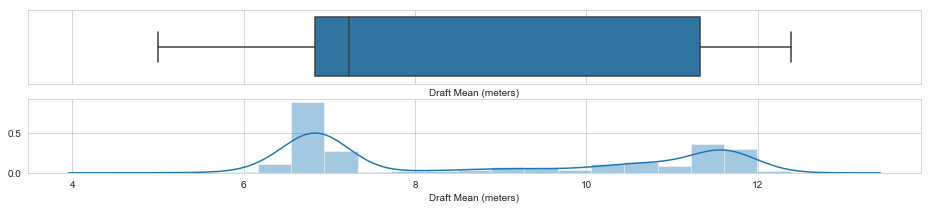

In [45]:
# Draft
feat = 'Draft Mean (meters)'

plt.subplots(figsize=(16,1.5))
df_feat[feat].plot()

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_feat[feat], ax=ax_box)
sns.distplot(df_feat[feat], ax=ax_hist)

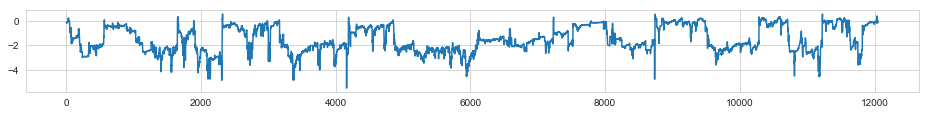

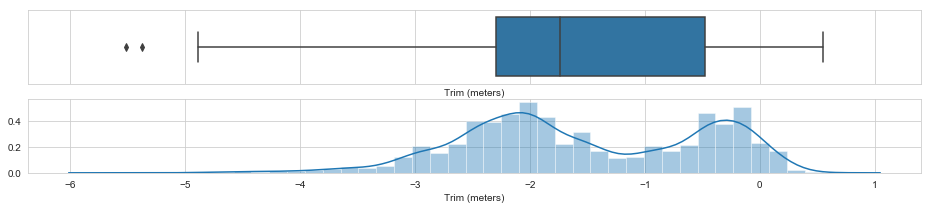

In [46]:
# Trim
feat = 'Trim (meters)'

plt.subplots(figsize=(16,1.5))
df_feat[feat].plot()

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_feat[feat], ax=ax_box)
sns.distplot(df_feat[feat], ax=ax_hist)

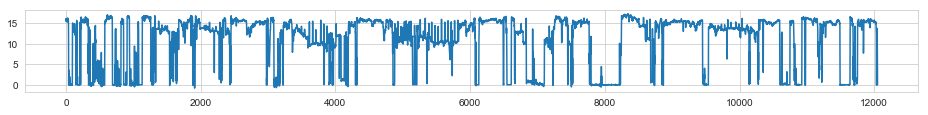

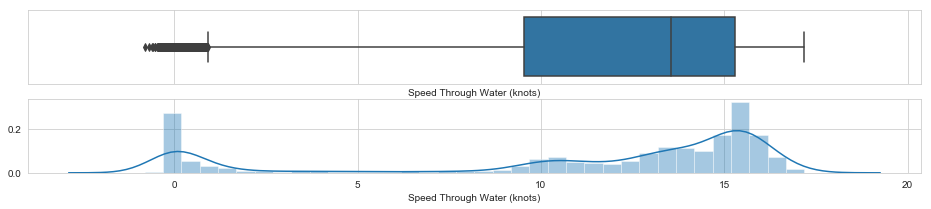

In [47]:
# Speed through water
feat = 'Speed Through Water (knots)'

plt.subplots(figsize=(16,1.5))
df_feat[feat].plot()

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_feat[feat], ax=ax_box)
sns.distplot(df_feat[feat], ax=ax_hist)

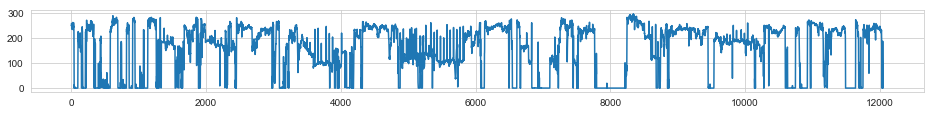

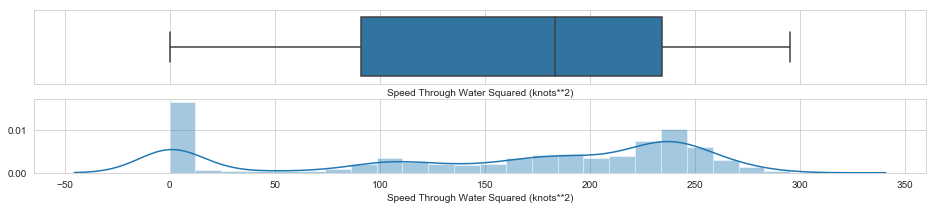

In [48]:
# Speed through water squared
feat = 'Speed Through Water Squared (knots**2)'

plt.subplots(figsize=(16,1.5))
df_feat[feat].plot()

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_feat[feat], ax=ax_box)
sns.distplot(df_feat[feat], ax=ax_hist)

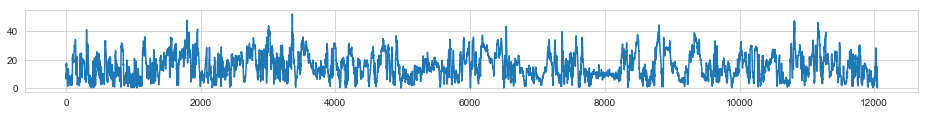

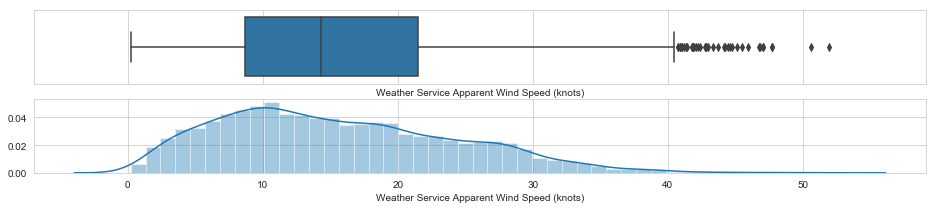

In [49]:
# Apparent wind speed
feat = 'Weather Service Apparent Wind Speed (knots)'

plt.subplots(figsize=(16,1.5))
df_feat[feat].plot()

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_feat[feat], ax=ax_box)
sns.distplot(df_feat[feat], ax=ax_hist)

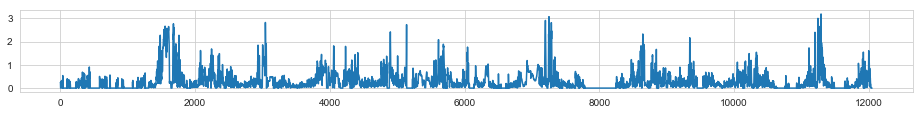

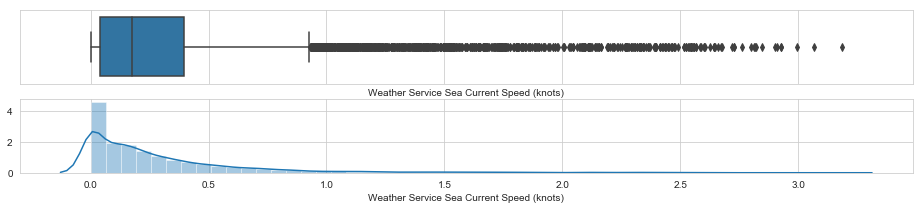

In [50]:
# Sea current speed
feat = 'Weather Service Sea Current Speed (knots)'

plt.subplots(figsize=(16,1.5))
df_feat[feat].plot()

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(16,2*1.5), sharex=True)
sns.boxplot( df_feat[feat], ax=ax_box)
sns.distplot(df_feat[feat], ax=ax_hist)

# Regression Modeling

In [51]:
# Set target and feature variables
y = df_feat[     'Main Engine Fuel Consumption (MT/day)']
X = df_feat.drop('Main Engine Fuel Consumption (MT/day)',axis=1)

# Training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(9640, 6)
(2410, 6)


In [52]:
# Train regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Print feature coefficients
features                = pd.DataFrame(X.columns.T, columns=['Feature'])
features['Coefficient'] = reg.coef_.T
features                = features.append({'Feature': 'Intercept','Coefficient': reg.intercept_}, ignore_index=True)
features                = features.set_index('Feature')

# Print range of feature variability
features = features.merge(pd.DataFrame(X_train.min(),columns=['Min Limit']),
                          left_index=True,right_index=True,how='left')
features = features.merge(pd.DataFrame(X_train.max(),columns=['Max Limit']),
                          left_index=True,right_index=True,how='left')

# Print range of feature effects
features['Min Effect']  = features['Coefficient'] * features['Min Limit']
features['Max Effect']  = features['Coefficient'] * features['Max Limit']
features.sort_values(by='Max Effect',ascending=False)

Coefficient  Min Limit  \
Feature                                                               
Speed Through Water Squared (knots**2)          0.206249   0.000000   
Draft Mean (meters)                             1.517743   4.999963   
Weather Service Apparent Wind Speed (knots)     0.316038   0.216047   
Trim (meters)                                  -1.750337  -5.511462   
Weather Service Sea Current Speed (knots)      -0.377034   0.000000   
Speed Through Water (knots)                    -0.855024  -0.812132   
Intercept                                     -17.723875        NaN   

                                              Max Limit  Min Effect  \
Feature                                                               
Speed Through Water Squared (knots**2)       294.146974    0.000000   
Draft Mean (meters)                           12.385497    7.588660   
Weather Service Apparent Wind Speed (knots)   51.955335    0.068279   
Trim (meters)                                  0.547380    9.646916   
Weather Service Sea Current Speed (knots)      3.184603   -0.000000   
Speed Through Water (knots)                   17.150714    0.694393   
Intercept                                           NaN         NaN   

                                             Max Effect  
Feature                                                  
Speed Through Water Squared (knots**2)        60.667466  
Draft Mean (meters)                           18.798004  
Weather Service Apparent Wind Speed (knots)   16.419861  
Trim (meters)                                 -0.958099  
Weather Service Sea Current Speed (knots)     -1.200702  
Speed Through Water (knots)                  -14.664267  
Intercept                                           NaN

R-squared score:         0.968
Root mean squared error: 3.004


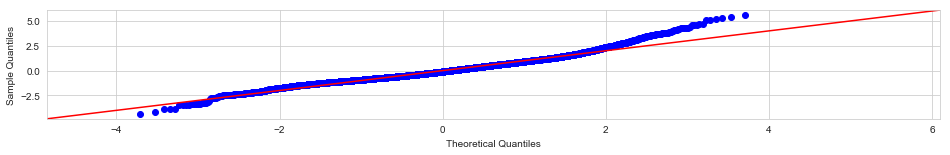

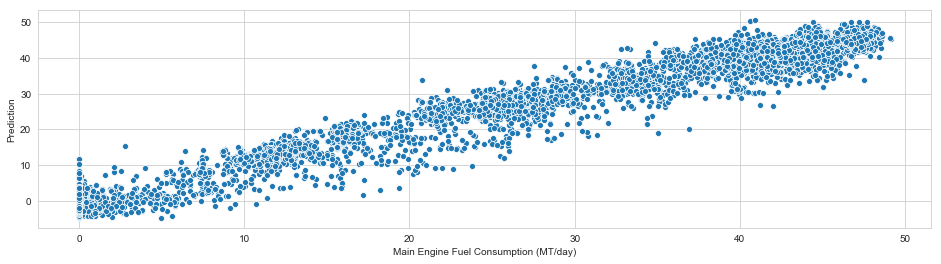

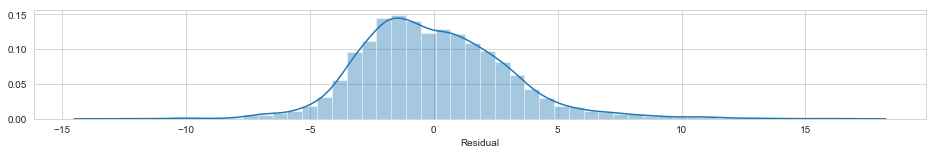

In [53]:
# Predictions of training set
X_train['Prediction'] = reg.predict(X_train)
print('R-squared score:         %.3f' % r2_score(y_train, X_train['Prediction']))
print("Root mean squared error: %.3f" % np.sqrt(mean_squared_error(y_train, X_train['Prediction'])))

# Residuals of training set
X_train['Residual'] = y_train - X_train['Prediction']

# Examine normality of residuals
fig, ax = plt.subplots(figsize=(16,2))
sm.graphics.qqplot(X_train['Residual'], dist=stats.norm, line='45', fit=True, ax=ax)

plt.figure(figsize=(16,4))
sns.scatterplot(x    = y_train,
                y    = X_train['Prediction'])

# Plot distributions of residuals
plt.subplots(figsize=(16,2))
sns.distplot(X_train['Residual'])

In [54]:
# Investigate regression outliers
reg_outliers               = X_train.copy()
reg_outliers[cols_main[1]] = y_train
reg_outliers               = reg_outliers[
    (reg_outliers['Residual'] >  np.sqrt(mean_squared_error(y_train,  reg_outliers['Prediction']))) |
    (reg_outliers['Residual'] < -np.sqrt(mean_squared_error(y_train,  reg_outliers['Prediction'])))]
print(reg_outliers.shape)

# Positive tail of residuals
reg_outliers.sort_values(by='Residual',ascending=False).head()

(2623, 9)


Draft Mean (meters)  Trim (meters)  Speed Through Water (knots)  \
8744             12.102599       0.535530                    10.578649   
2319             12.352615       0.510134                    10.280222   
2316             12.087561       0.137208                     3.573806   
3163              9.191425       0.065063                     6.311036   
11217             7.044886      -2.080213                    13.788728   

       Speed Through Water Squared (knots**2)  \
8744                               111.907808   
2319                               105.682966   
2316                                12.772092   
3163                                39.829172   
11217                              190.129019   

       Weather Service Apparent Wind Speed (knots)  \
8744                                     20.102717   
2319                                     18.253801   
2316                                     11.186925   
3163                                      8.151673   
11217                                     8.048230   

       Weather Service Sea Current Speed (knots)  Prediction   Residual  \
8744                                         0.0   20.096486  16.805061   
2319                                         0.0   18.907364  16.123470   
2316                                         0.0    3.495812  15.847850   
3163                                         0.0    1.507338  15.707373   
11217                                        0.0   26.577268  15.395669   

       Main Engine Fuel Consumption (MT/day)  
8744                               36.901547  
2319                               35.030834  
2316                               19.343662  
3163                               17.214711  
11217                              41.972938

In [55]:
# Negative tail of residuals 
reg_outliers.sort_values(by='Residual').head()

Draft Mean (meters)  Trim (meters)  Speed Through Water (knots)  \
5176              7.138948      -2.884555                    14.426480   
10816             9.651735      -3.306544                     3.369995   
10822             9.927602      -2.501662                     0.185178   
10823             9.927206      -2.501390                     0.182065   
10821             9.927402      -2.501614                     0.331964   

       Speed Through Water Squared (knots**2)  \
5176                               208.123332   
10816                               11.356868   
10822                                0.034291   
10823                                0.033148   
10821                                0.110200   

       Weather Service Apparent Wind Speed (knots)  \
5176                                     16.068788   
10816                                    41.458107   
10822                                    32.055116   
10823                                    32.040379   
10821                                    31.961151   

       Weather Service Sea Current Speed (knots)  Prediction   Residual  \
5176                                         0.0   33.828715 -13.082735   
10816                                        0.0   15.275799 -12.479847   
10822                                        0.0   11.701803 -11.701803   
10823                                        0.0   11.698495 -11.698495   
10821                                        0.0   11.561871 -11.561871   

       Main Engine Fuel Consumption (MT/day)  
5176                               20.745980  
10816                               2.795952  
10822                               0.000000  
10823                               0.000000  
10821                               0.000000

R-squared score:         0.971
Root mean squared error: 2.863


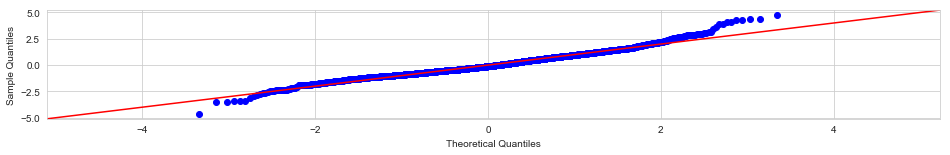

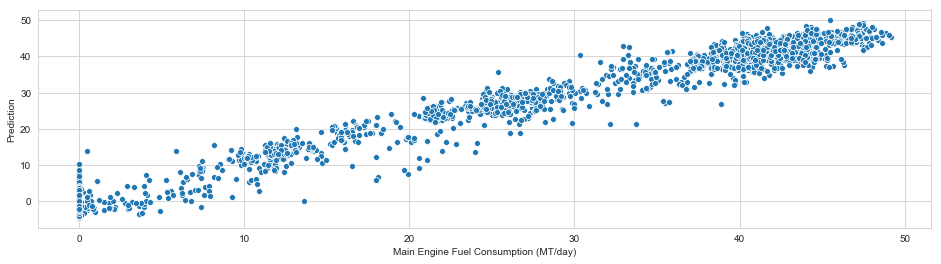

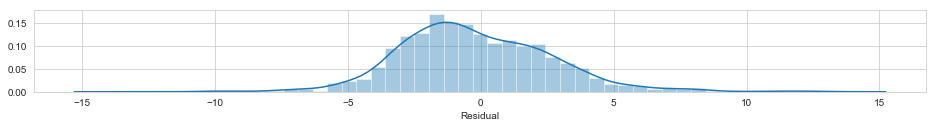

In [56]:
# Predictions of test set
X_test['Prediction'] = reg.predict(X_test)
print('R-squared score:         %.3f' % r2_score(y_test,  X_test['Prediction']))
print("Root mean squared error: %.3f" % np.sqrt(mean_squared_error(y_test,  X_test['Prediction'])))

# Residuals of test set
X_test['Residual'] = y_test - X_test['Prediction']

# Examine normality of residuals
fig, ax = plt.subplots(figsize=(16,2))
sm.graphics.qqplot(X_test['Residual'], dist=stats.norm, line='45', fit=True, ax=ax)

plt.figure(figsize=(16,4))
sns.scatterplot(x    = y_test,
                y    = X_test['Prediction'])

# Plot distributions of residuals
plt.subplots(figsize=(16,1.5))
sns.distplot(X_test['Residual'])

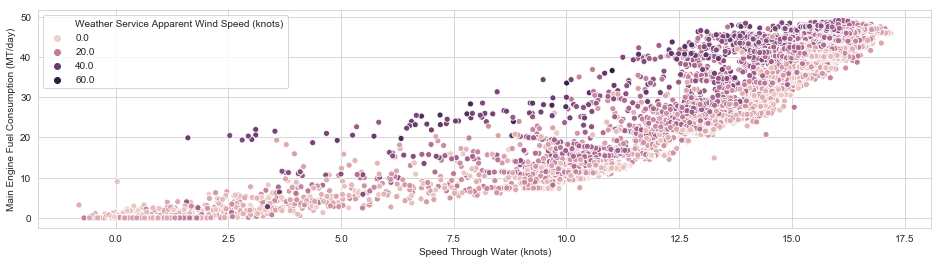

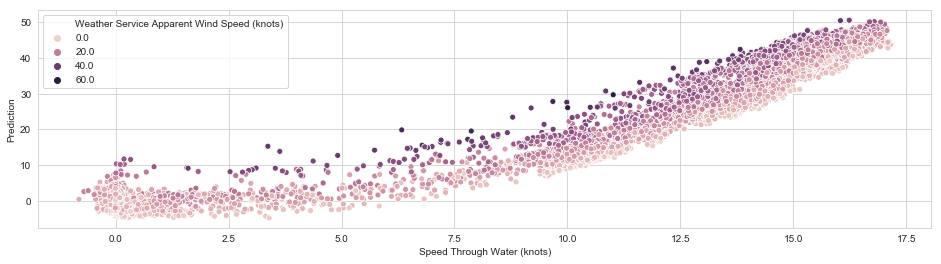

In [57]:
# Ground truth of feature data
plt.figure(figsize=(16,4))
sns.scatterplot(x    = 'Speed Through Water (knots)',
                y    = 'Main Engine Fuel Consumption (MT/day)',
                hue  = 'Weather Service Apparent Wind Speed (knots)',
                data = df_feat)

# Predictions of training set
plt.figure(figsize=(16,4))
sns.scatterplot(x    = 'Speed Through Water (knots)',
                y    = 'Prediction',
                hue  = 'Weather Service Apparent Wind Speed (knots)',
                data = X_train)

# Vessel Performance

In [58]:
# Find bounding limits of features
df_feat.describe()

Main Engine Fuel Consumption (MT/day)  Draft Mean (meters)  \
count                           12050.000000         12050.000000   
mean                               25.325917             8.802599   
std                                16.704775             2.151936   
min                                 0.000000             4.999963   
25%                                10.794542             6.828962   
50%                                26.989658             7.229396   
75%                                41.131036            11.328492   
max                                49.138823            12.385497   

       Trim (meters)  Speed Through Water (knots)  \
count   12050.000000                 12050.000000   
mean       -1.532498                    10.943489   
std         1.036170                     5.790983   
min        -5.511462                    -0.812132   
25%        -2.297666                     9.550677   
50%        -1.739662                    13.537377   
75%        -0.477947                    15.307272   
max         0.547380                    17.186902   

       Speed Through Water Squared (knots**2)  \
count                            12050.000000   
mean                               153.292661   
std                                 93.667111   
min                                  0.000000   
25%                                 91.215432   
50%                                183.260586   
75%                                234.312567   
max                                295.389611   

       Weather Service Apparent Wind Speed (knots)  \
count                                 12050.000000   
mean                                     15.512888   
std                                       8.641331   
min                                       0.216047   
25%                                       8.716256   
50%                                      14.280058   
75%                                      21.512593   
max                                      51.955335   

       Weather Service Sea Current Speed (knots)  
count                               12050.000000  
mean                                    0.305126  
std                                     0.411720  
min                                     0.000000  
25%                                     0.039177  
50%                                     0.175924  
75%                                     0.394922  
max                                     3.184603

In [59]:
# Create feature levels
x_draft  = np.linspace(  5.0,   12.0,  8)
x_trim   = np.linspace( -5.0,    0.0,  6)
x_water  = np.linspace(  0.0,   20.0, 21)
x_wind   = np.linspace(  0.0,   50.0,  6)
x_sea    = np.linspace(  0.0,    3.0,  4)

# Mesh features
X_draft, X_trim, X_water, X_wind, X_sea = np.meshgrid(x_draft, x_trim, x_water, x_wind, x_sea)

# Create Pandas DataFrame
df_score                                                = pd.DataFrame(
    X_draft.flatten(), columns = ['Draft Mean (meters)'])
df_score['Trim (meters)']                               = X_trim.flatten()
df_score['Speed Through Water (knots)']                 = X_water.flatten()
df_score['Speed Through Water (knots**2)']              = df_score['Speed Through Water (knots)'] ** 2
df_score['Weather Service Apparent Wind Speed (knots)'] = X_wind.flatten()
df_score['Weather Service Sea Current Speed (knots)']   = X_sea.flatten()

# Predict fuel consumption
df_score['Main Engine Fuel Consumption (MT/day)']       = reg.predict(df_score)

# Show Pandas DataFrame
print(df_score.shape)
df_score.head()

(24192, 7)


Draft Mean (meters)  Trim (meters)  Speed Through Water (knots)  \
0                  5.0           -5.0                          0.0   
1                  5.0           -5.0                          0.0   
2                  5.0           -5.0                          0.0   
3                  5.0           -5.0                          0.0   
4                  5.0           -5.0                          0.0   

   Speed Through Water (knots**2)  \
0                             0.0   
1                             0.0   
2                             0.0   
3                             0.0   
4                             0.0   

   Weather Service Apparent Wind Speed (knots)  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                         10.0   

   Weather Service Sea Current Speed (knots)  \
0                                        0.0   
1                                        1.0   
2                                        2.0   
3                                        3.0   
4                                        0.0   

   Main Engine Fuel Consumption (MT/day)  
0                              -1.383474  
1                              -1.760507  
2                              -2.137541  
3                              -2.514574  
4                               1.776906

In [60]:
df_score.describe()

Draft Mean (meters)  Trim (meters)  Speed Through Water (knots)  \
count         24192.000000    24192.00000                 24192.000000   
mean              8.500000       -2.50000                    10.000000   
std               2.291335        1.70786                     6.055426   
min               5.000000       -5.00000                     0.000000   
25%               6.750000       -4.00000                     5.000000   
50%               8.500000       -2.50000                    10.000000   
75%              10.250000       -1.00000                    15.000000   
max              12.000000        0.00000                    20.000000   

       Speed Through Water (knots**2)  \
count                    24192.000000   
mean                       136.666667   
std                        125.441378   
min                          0.000000   
25%                         25.000000   
50%                        100.000000   
75%                        225.000000   
max                        400.000000   

       Weather Service Apparent Wind Speed (knots)  \
count                                 24192.000000   
mean                                     25.000000   
std                                      17.078604   
min                                       0.000000   
25%                                      10.000000   
50%                                      25.000000   
75%                                      40.000000   
max                                      50.000000   

       Weather Service Sea Current Speed (knots)  \
count                               24192.000000   
mean                                    1.500000   
std                                     1.118057   
min                                     0.000000   
25%                                     0.750000   
50%                                     1.500000   
75%                                     2.250000   
max                                     3.000000   

       Main Engine Fuel Consumption (MT/day)  
count                           24192.000000  
mean                               26.525287  
std                                22.087580  
min                               -12.151312  
25%                                 9.120015  
50%                                20.312980  
75%                                42.162243  
max                                90.441683

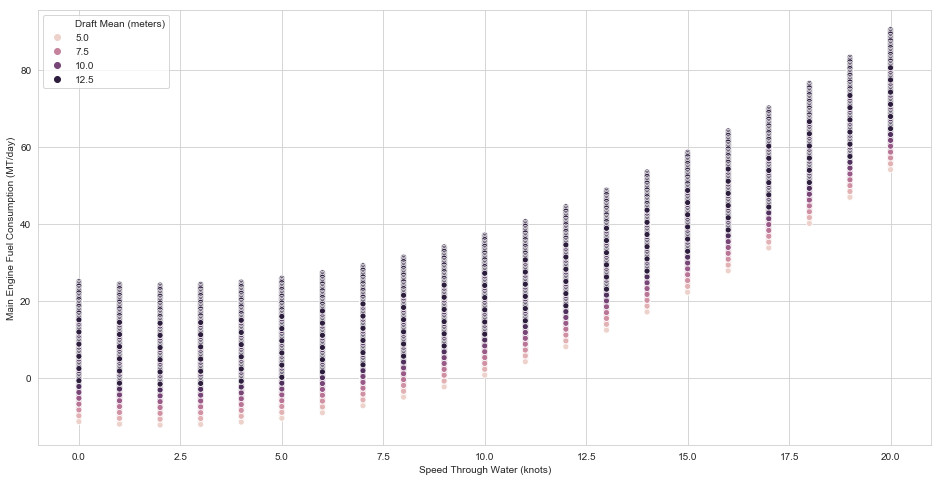

In [61]:
# Samples
plt.figure(figsize=(16,8))
sns.scatterplot(x    = 'Speed Through Water (knots)',
                y    = 'Main Engine Fuel Consumption (MT/day)',
                hue  = 'Draft Mean (meters)',
                data = df_score)

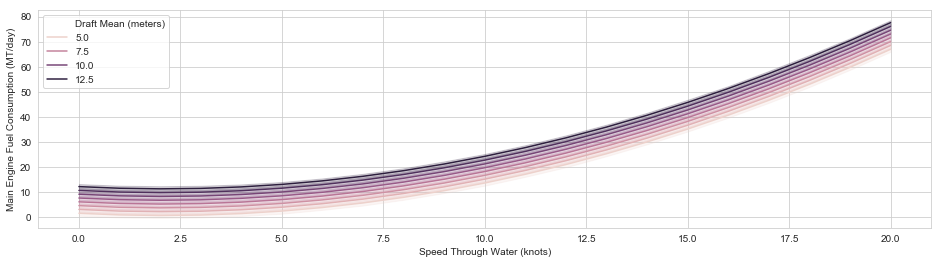

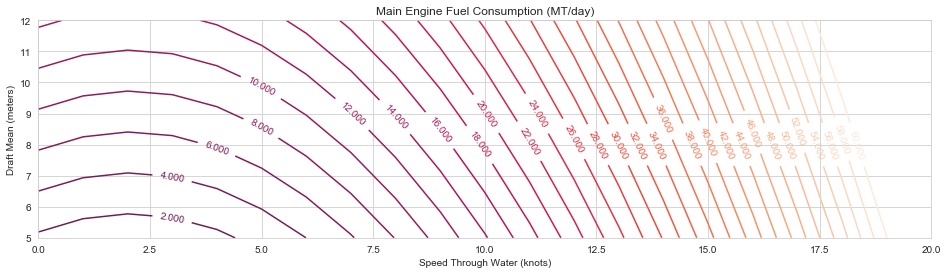

In [62]:
# Effect of draft
plt.figure(figsize=(16,4))
sns.lineplot(x    = 'Speed Through Water (knots)',
             y    = 'Main Engine Fuel Consumption (MT/day)',
             hue  = 'Draft Mean (meters)',
             data = df_score)

# Effect of draft
df_plot = df_score[df_score['Weather Service Apparent Wind Speed (knots)'] ==   30.0]
df_plot = df_plot[ df_plot[ 'Trim (meters)']                               ==   -2.0]
df_plot = df_plot[ df_plot[ 'Weather Service Sea Current Speed (knots)']   ==    3.0]

df_plot = df_plot.pivot(index   = 'Speed Through Water (knots)',
                        columns = 'Draft Mean (meters)',
                        values  = 'Main Engine Fuel Consumption (MT/day)')

# Contour plot
plt.figure(figsize = (16,4))
X_plot, Y_plot = np.meshgrid(x_water, x_draft)
Z_plot         = df_plot.values.T
levels         = np.linspace(-20.0,60.0,41)
CS             = plt.contour(X_plot, Y_plot, Z_plot, levels=levels)
plt.clabel(CS, inline=1, fontsize=10)
plt.title( 'Main Engine Fuel Consumption (MT/day)'.format(levels.tolist()))
plt.xlabel('Speed Through Water (knots)')
plt.ylabel('Draft Mean (meters)')
plt.show()

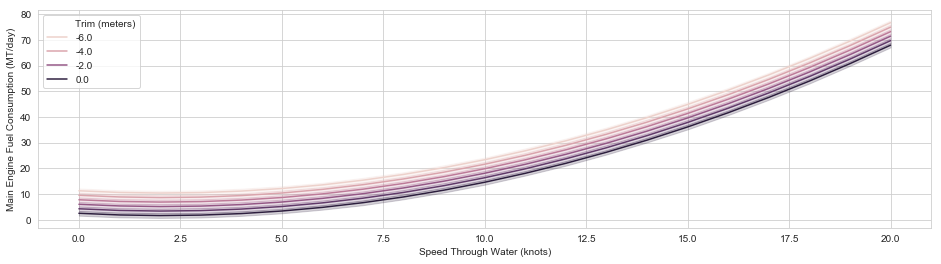

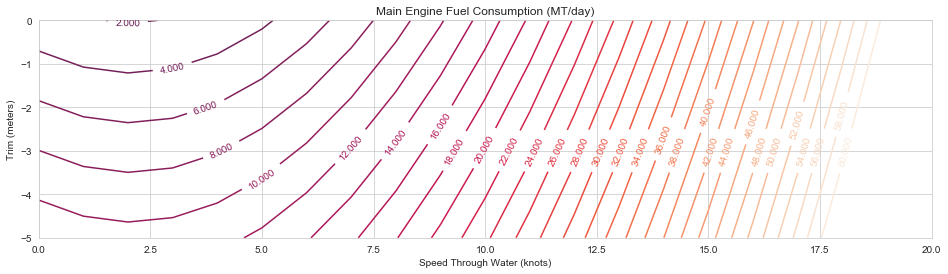

In [63]:
# Effect of trim
plt.figure(figsize=(16,4))
sns.lineplot(x    = 'Speed Through Water (knots)',
             y    = 'Main Engine Fuel Consumption (MT/day)',
             hue  = 'Trim (meters)',
             data = df_score)

# Effect of trim
df_plot = df_score[df_score['Weather Service Apparent Wind Speed (knots)'] ==   30.0]
df_plot = df_plot[ df_plot[ 'Draft Mean (meters)']                         ==    8.0]
df_plot = df_plot[ df_plot[ 'Weather Service Sea Current Speed (knots)']   ==    3.0]

df_plot = df_plot.pivot(index   = 'Speed Through Water (knots)',
                        columns = 'Trim (meters)',
                        values  = 'Main Engine Fuel Consumption (MT/day)')

# Contour plot
plt.figure(figsize = (16,4))
X_plot, Y_plot = np.meshgrid(x_water, x_trim)
Z_plot         = df_plot.values.T
levels         = np.linspace(-20.0,60.0,41)
CS             = plt.contour(X_plot, Y_plot, Z_plot, levels=levels)
plt.clabel(CS, inline=1, fontsize=10)
plt.title( 'Main Engine Fuel Consumption (MT/day)'.format(levels.tolist()))
plt.xlabel('Speed Through Water (knots)')
plt.ylabel('Trim (meters)')
plt.show()

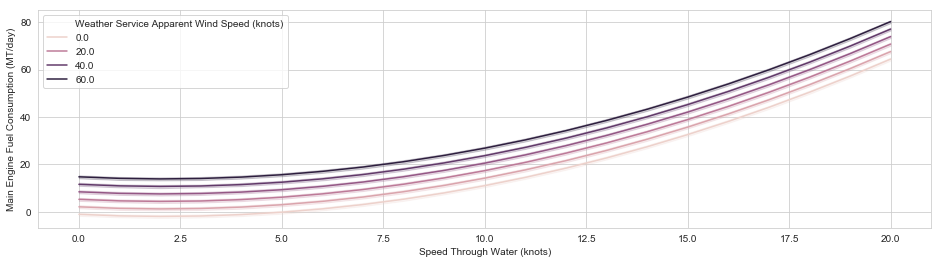

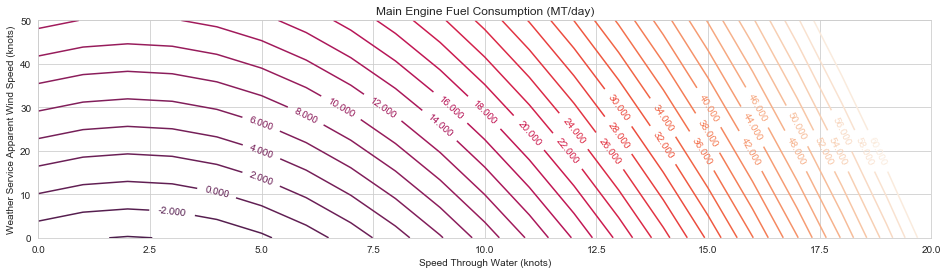

In [64]:
# Effect of wind
plt.figure(figsize=(16,4))
sns.lineplot(x    = 'Speed Through Water (knots)',
             y    = 'Main Engine Fuel Consumption (MT/day)',
             hue  = 'Weather Service Apparent Wind Speed (knots)',
             data = df_score)

# Effect of wind
df_plot = df_score[df_score['Trim (meters)']                               ==   -2.0]
df_plot = df_plot[ df_plot[ 'Draft Mean (meters)']                         ==    8.0]
df_plot = df_plot[ df_plot[ 'Weather Service Sea Current Speed (knots)']   ==    3.0]

df_plot = df_plot.pivot(index   = 'Speed Through Water (knots)',
                        columns = 'Weather Service Apparent Wind Speed (knots)',
                        values  = 'Main Engine Fuel Consumption (MT/day)')

# Contour plot
plt.figure(figsize = (16,4))
X_plot, Y_plot = np.meshgrid(x_water, x_wind)
Z_plot         = df_plot.values.T
levels         = np.linspace(-20.0,60.0,41)
CS             = plt.contour(X_plot, Y_plot, Z_plot, levels=levels)
plt.clabel(CS, inline=1, fontsize=10)
plt.title( 'Main Engine Fuel Consumption (MT/day)'.format(levels.tolist()))
plt.xlabel('Speed Through Water (knots)')
plt.ylabel('Weather Service Apparent Wind Speed (knots)')
plt.show()

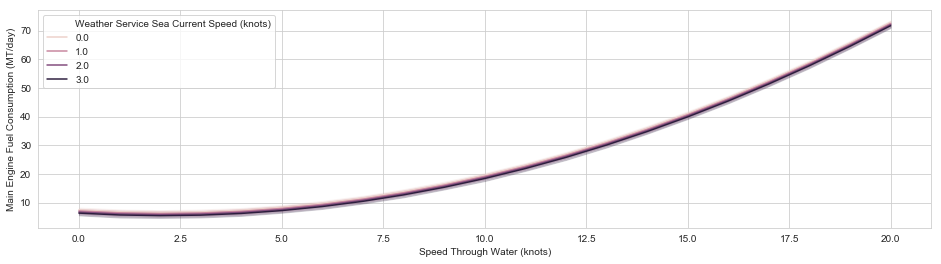

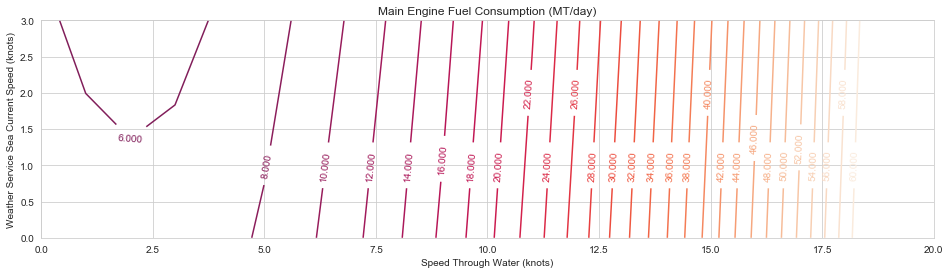

In [65]:
# Effect of sea current
plt.figure(figsize=(16,4))
sns.lineplot(x    = 'Speed Through Water (knots)',
             y    = 'Main Engine Fuel Consumption (MT/day)',
             hue  = 'Weather Service Sea Current Speed (knots)',
             data = df_score)

# Effect of sea current
df_plot = df_score[df_score['Trim (meters)']                               ==   -2.0]
df_plot = df_plot[ df_plot[ 'Draft Mean (meters)']                         ==    8.0]
df_plot = df_plot[ df_plot[ 'Weather Service Apparent Wind Speed (knots)'] ==   30.0]

df_plot = df_plot.pivot(index   = 'Speed Through Water (knots)',
                        columns = 'Weather Service Sea Current Speed (knots)',
                        values  = 'Main Engine Fuel Consumption (MT/day)')

# Contour plot
plt.figure(figsize = (16,4))
X_plot, Y_plot = np.meshgrid(x_water, x_sea)
Z_plot         = df_plot.values.T
levels         = np.linspace(-20.0,60.0,41)
CS             = plt.contour(X_plot, Y_plot, Z_plot, levels=levels)
plt.clabel(CS, inline=1, fontsize=10)
plt.title( 'Main Engine Fuel Consumption (MT/day)'.format(levels.tolist()))
plt.xlabel('Speed Through Water (knots)')
plt.ylabel('Weather Service Sea Current Speed (knots)')
plt.show()

# Sensor Drift

Speed Through Water (knots)  Speed Over Ground (knots)  \
Time                                                                          
2017-07-06 13:15:00                    15.607449                  15.463448   
2017-07-06 14:00:00                    15.776289                  15.744354   
2017-07-06 15:00:00                    15.707046                  15.939796   
2017-07-06 16:00:00                    15.723442                  16.135230   
2017-07-06 17:00:00                    15.692471                  16.176168   

                     Speed Difference  
Time                                   
2017-07-06 13:15:00          0.144001  
2017-07-06 14:00:00          0.031935  
2017-07-06 15:00:00         -0.232750  
2017-07-06 16:00:00         -0.411788  
2017-07-06 17:00:00         -0.483697

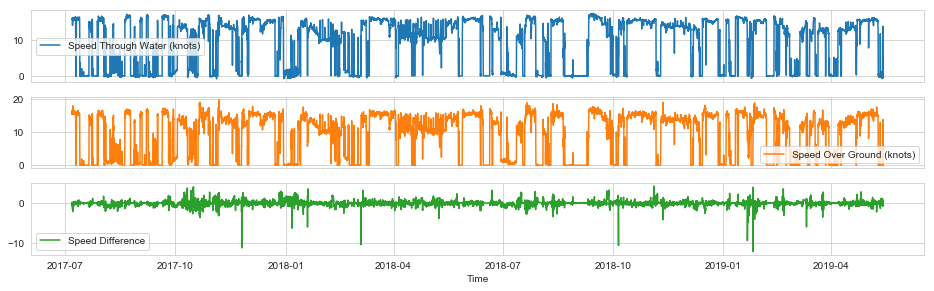

In [130]:
# Calculative difference between speed through water and speed over ground
df_sensor                     = df_raw[['Time','Speed Through Water (knots)','Speed Over Ground (knots)']]
df_sensor                     = df_sensor.copy().dropna()
df_sensor['Time']             = pd.to_datetime(df_sensor['Time'], unit='s')
df_sensor['Speed Difference'] = df_sensor['Speed Through Water (knots)'] - df_sensor['Speed Over Ground (knots)']
df_sensor.set_index('Time', inplace = True)

# Speed through water sensor
fig_sensor, axes_sensor = plt.subplots(3,1, figsize=(16,3*1.5), sharex=True)
df_sensor[['Speed Through Water (knots)',
           'Speed Over Ground (knots)',
           'Speed Difference']].plot(subplots=True, ax=axes_sensor)

df_sensor.head()

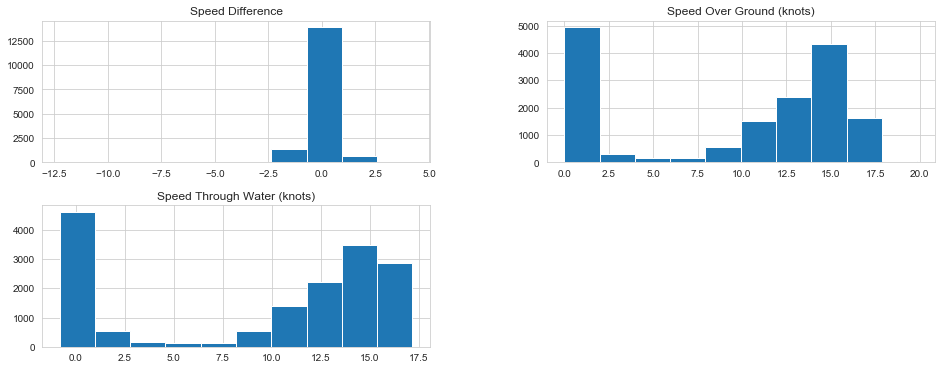

In [138]:
# Sensor histogram
df_sensor.hist(figsize = (16,6))
plt.show()

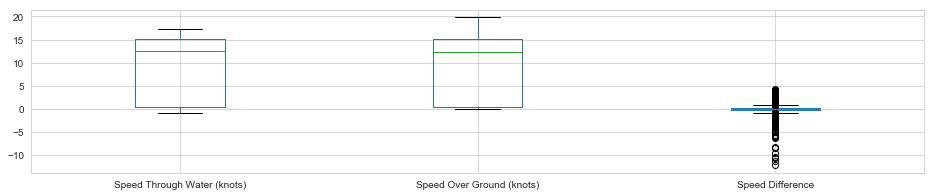

In [140]:
# Daily sensor outliers
df_sensor.boxplot(figsize = (16,3))
plt.show()

Speed Through Water (knots)  Speed Over Ground (knots)  \
Time                                                                 
2017-07-01                     7.580010                   7.641705   
2017-08-01                     4.329728                   4.675134   
2017-09-01                     5.577536                   5.720584   
2017-10-01                     9.552025                   9.621117   
2017-11-01                     9.961908                   9.926372   

            Speed Difference  
Time                          
2017-07-01         -0.061695  
2017-08-01         -0.345406  
2017-09-01         -0.143048  
2017-10-01         -0.069092  
2017-11-01          0.035536

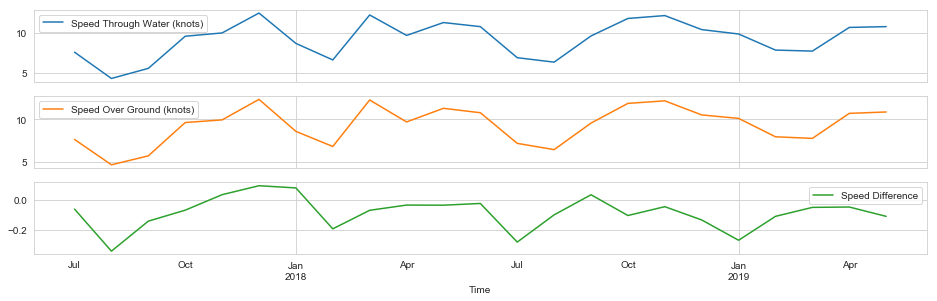

In [131]:
# Monthly mean of sensor data
monthly_mean = df_sensor.resample('MS').mean()

# Speed through water sensor
fig_sensor, axes_sensor = plt.subplots(3,1, figsize=(16,3*1.5), sharex=True)
monthly_mean[['Speed Through Water (knots)',
              'Speed Over Ground (knots)',
              'Speed Difference']].plot(subplots=True, ax=axes_sensor)

monthly_mean.head()

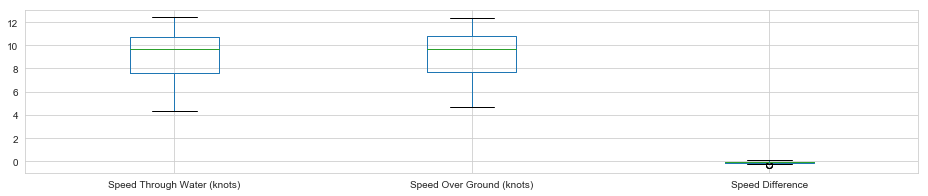

In [141]:
# Monthly sensor outliers
monthly_mean.boxplot(figsize = (16,3))
plt.show()

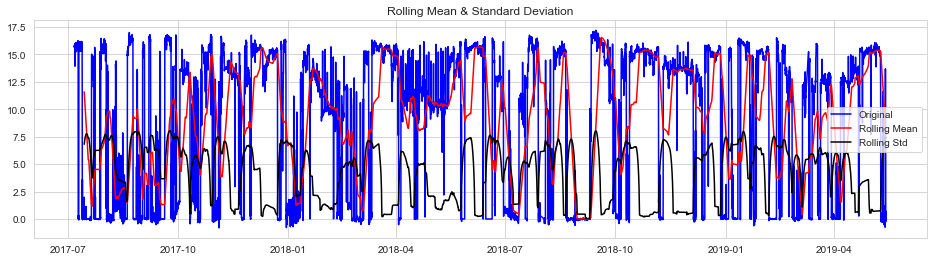

In [155]:
# Rolling Statistics
roll_mean = df_sensor.rolling(window = 200, center = False).mean()
roll_std  = df_sensor.rolling(window = 200, center = False).std()

fig = plt.figure(figsize=(16,4))
orig = plt.plot(df_sensor['Speed Through Water (knots)'], color='blue',  label='Original')
mean = plt.plot(roll_mean['Speed Through Water (knots)'], color='red',   label='Rolling Mean')
std  = plt.plot(roll_std[ 'Speed Through Water (knots)'], color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

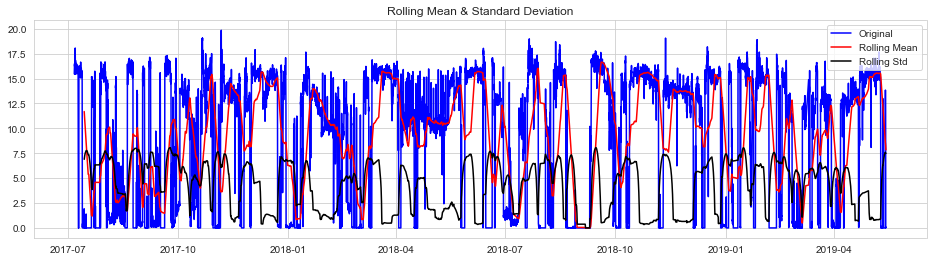

In [156]:
fig = plt.figure(figsize=(16,4))
orig = plt.plot(df_sensor['Speed Over Ground (knots)'], color='blue',  label='Original')
mean = plt.plot(roll_mean['Speed Over Ground (knots)'], color='red',   label='Rolling Mean')
std  = plt.plot(roll_std[ 'Speed Over Ground (knots)'], color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

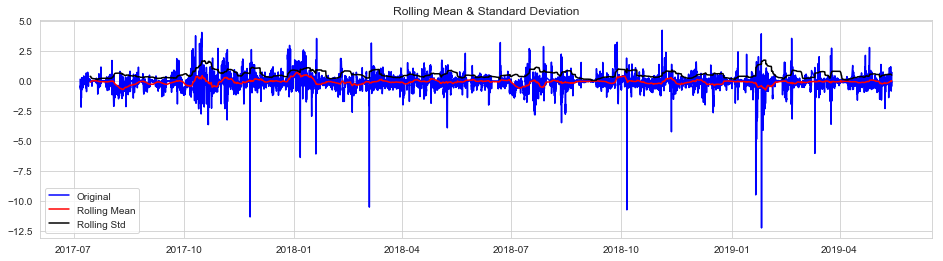

In [157]:
fig = plt.figure(figsize=(16,4))
orig = plt.plot(df_sensor['Speed Difference'], color='blue',  label='Original')
mean = plt.plot(roll_mean['Speed Difference'], color='red',   label='Rolling Mean')
std  = plt.plot(roll_std[ 'Speed Difference'], color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [160]:
# Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df_sensor['Speed Difference'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print ('Results of Dickey-Fuller Test:')
print(dfoutput)

(-21.19634121727679, 0.0, 16, 16068, {'1%': -3.430757041635098, '5%': -2.8617198956721555, '10%': -2.5668657539718396}, 16332.604159351755)
Results of Dickey-Fuller Test:
Test Statistic                   -21.196341
p-value                            0.000000
#Lags Used                        16.000000
Number of Observations Used    16068.000000
Critical Value (1%)               -3.430757
Critical Value (5%)               -2.861720
Critical Value (10%)              -2.566866
dtype: float64


In [163]:
# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_sensor['Speed Difference'])

# Gather the trend, seasonality and noise of decomposed object
trend    = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(ts), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

ValueError: You must specify a freq or x must be a pandas object with a timeseries index with a freq not set to None